In [30]:
# # maybe run these maybe don't, depends on how clean you want your system
# !pip3 install matplotlib
# !pip3 install pandas
# !pip3 install scipy
# !pip3 install sympy
# !pip3 install numpy
# !pip3 install xarray
# # See here for better xarray install instructions https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
# !pip3 install toolz
# !pip3 install treeop
# !pip3 install ipywidgets
# # Widgets didn't work for me until I ran
# !jupyter nbextension enable --py widgetsnbextension --sys-prefix
# # in a terminal, you may need to as well, perhaps running it from JupyterLab will work

# Initial definitions and imports

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# with the above line figures won't show iff you call fig.close()
# but can be shown if they are returned (are the only thing on its
# last line) by the cell
import pandas as pd
from time import sleep
from os import getcwd
import os
import pathlib
from datetime import datetime
import math
from math import ceil
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import scipy
import subprocess
import itertools
from functools import reduce
import toolz
from collections import defaultdict
import ipywidgets as widgets
from functools import lru_cache
from functools import cache
from functools import cached_property
import functools
import matplotlib.colors as mcolors
import random
import matplotlib.patches
import matplotlib.patches as mpatches


def memoize(f): # Memoize a given function f
    def memf(*x):
        if x not in memf.cache:
            memf.cache[x] = f(*x)
        return memf.cache[x]
    memf.cache = {}
    return memf


if not ('fileLastModifiedTimes' in vars() or 'fileLastModifiedTimes' in globals()):
    fileLastModifiedTimes = {}

if not ('storageForGetData' in vars() or 'storageForGetData' in globals()):
    storageForGetData = {}

# I should rewrite this to simply use the @cache property of functools and 
# to have an optional argument that gets the max rows
def getData(filename):
    if (filename in fileLastModifiedTimes) and (fileLastModifiedTimes[filename] == os.path.getmtime(filename)):
        return storageForGetData[filename]
    else:
        fileLastModifiedTimes[filename] = os.path.getmtime(filename)
        storageForGetData[filename] = np.array(np.genfromtxt(filename, skip_header=0, dtype=float))
        return storageForGetData[filename]
    

def getDataNoMemoize(filename):
    return np.array(np.genfromtxt(filename, skip_header=0, dtype=float))


# Searchs the file system for files whose name contains the given strings
# Distributes over lists (thus performs an outer product when given multiple lists)
# When given a dictionary treats the values as strings to be searched for, but makes the
# keys of the resulting dictionary the keys of the input dictionary
# Screws up on any nesting of these data types, ie it can't handle lists including dictionaries
# or dictionaries valued by lists
# It could work in these cases, but I haven't bothered to implement it yet
# Perhaps one could also use tuples (or some custom StringExpression data type) to allow nesting
# of include and dontInclude specifications as well, this would be even more work though
def search(*matchItems, include=[], dontInclude=[], unique=False): 
    if type(include) == str:
        return search(*matchItems, include=[include], dontInclude=dontInclude, unique=unique)
    if type(dontInclude) == str:
        return search(*matchItems, include=include, dontInclude=[dontInclude], unique=unique)
    if len(matchItems) != 0:
        matchItem = matchItems[0]
        if type(matchItem) == str:
            return {matchItem : search(*matchItems[1:], include=[matchItem, *include], dontInclude=dontInclude, unique=unique)}
        elif type(matchItem) == list:
            return {matchString : search(*matchItems[1:], include=[matchString, *include], dontInclude=dontInclude, unique=unique) for matchString in matchItem}
            # return reduce(lambda d1, d2: {**d1, **d2}, [search(matchString, *matchItems[1:], include=include, dontInclude=dontInclude, unique=unique) for matchString in matchItem])
        elif type(matchItem) == dict:
            return {matchItemKey : search(*matchItems[1:], include=[matchItemValue, *include], dontInclude=dontInclude, unique=unique) for matchItemKey,matchItemValue in matchItem.items()}
    filteredFilenames = [path for path in map(lambda p: p.as_posix(), pathlib.Path(os.getcwd()).rglob("*"))
        # if all([matchString in path for matchString in matchItems])
        if all([includeString in path for includeString in include])
        if not any([dontIncludeString in path for dontIncludeString in dontInclude])
    ]
    if unique: 
        if len(filteredFilenames) == 1:
            return filteredFilenames[0]
        elif len(filteredFilenames) == 0:
            return "no matches"
        else: 
            return "search not unique"
    else: 
        return filteredFilenames

In [2]:
# gives depth of a nested list. depth([[["Jeff"]]]) == 3
def depth(l):
    if isinstance(l, list):
        if len(l) == 0:
            return 1
        else: 
            return 1 + max(depth(item) for item in l)
    else:
        return 0

# bigListOfColors = ["blue", "orange", "green", "red", "purple", "brown", "pink", "grey", "olive", "cyan"]
# could be made larger, see https://matplotlib.org/stable/gallery/color/named_colors.html
bigListOfColors = list(mcolors.CSS4_COLORS.keys())
random.shuffle(bigListOfColors)

# converts a number to its ordinal ie 1 to 1st, 4 to 4th, etc
# taken from https://stackoverflow.com/a/20007730
def ordinal(n: int):
    if 11 <= (n % 100) <= 13:
        suffix = 'th'
    else:
        suffix = ['th', 'st', 'nd', 'rd', 'th'][min(n % 10, 4)]
    return str(n) + suffix

# Todo: add a legend to the plot

# would be good to maybe make this more functional in style, if I can get Python 3.9 
# to work I can used @functools.cached_property to simplify some of the code

# consider making a function that smooths the data using a rolling median, not a rolling
# mean and adding an option to the plot for this as a line, this would be much more robust to outliers 
class Spectrum:
    
    # data and resistance are the two necessary parameters
    # filename is saved for convenience but often spectra will not have
    # a filename since they were made from averaging or some other operation
    
    def __init__(self, filename, data, resistance):
        self.filename = filename
        self.data = data
        self.resistance = resistance
        def defaultFilterFunction(f, s): 
            fLimits = [1e2, 1e6]
            sLimits = [1e-15, 1e-7]
            fmod60 = round(f) % 60
            return (    (f > fLimits[0] and f < fLimits[1])
                    and (s > sLimits[0] and s < sLimits[1])
                    and not (fmod60 == 55 or fmod60 == 0 or fmod60 == 5))
        # a filter function should have type (frequency, power) -> boolean
        self.filters = [defaultFilterFunction]
        
        # these are just for memoizing
        self.filteredData = None
        self.smoothedData = None
        self.smoothingWindowSize = 1000
        self.smoothingStepSize = 100
        # fitParameters[0] is vSquared
        # fitParameters[1] is RCSquared
        self.fitParameters = None
        self.modelFunction = lambda f, fitParameter0, fitParameter1 : fitParameter0 / (1 + fitParameter1**2 * f**2)
        self.initialGuess = [1.5e-9 / 5 * 5, 1e-5]
        
    @staticmethod
    def fromData(data, resistance):
        return Spectrum("", np.array(data), resistance)
    
    @staticmethod
    def fromFilename(filename, resistance):
        return Spectrum(filename, getDataNoMemoize(filename), resistance)
    
    @staticmethod
    @cache
    def fromFilenameMemo(filename, resistance):
        return Spectrum(filename, getDataNoMemoize(filename), resistance)
    
    def getFilteredData(self):
        if type(self.filteredData) != np.ndarray:
            self.filteredData = np.array([(f, s) for (f, s) in self.data if all([filterFunction(f,s) for filterFunction in self.filters])])
        return self.filteredData
    
    # lets just have this not memoize for now; its not clear to me what the UX should be
    # it will mostly only get called by the plot function which will memoize, so theres not a huge issue
    def getSmoothedData(self): 
        i = 0
        smoothedSpectrum = []
        while i < len(self.data) - self.smoothingWindowSize + 1:
            window = self.data[i : i + self.smoothingWindowSize]
            windowAverageFrequency = sum(window[:,0]) / self.smoothingWindowSize
            windowAverageValue = sum(window[:,1]) / self.smoothingWindowSize
            smoothedSpectrum.append((windowAverageFrequency, windowAverageValue))
            i += self.smoothingStepSize
        self.smoothedData = np.array(smoothedSpectrum)
        return self.smoothedData
    
    def getFitParameters(self):
        if (type(self.fitParameters) != np.ndarray) and type(self.fitParameters) != list:
            self.getFilteredData()
            parameters, covariances = curve_fit(self.modelFunction, self.filteredData[:,0], self.filteredData[:,1], p0=self.initialGuess)
            self.fitParameters = parameters
            print("got here")
        return self.fitParameters
    
    def getMedianOfRange(self, limits = [9e3, 11e3]):
        return np.median(self.data[round(limits[0] / 5) : round(limits[1] / 5), 1])
        
    # Computes the effective temperature of the spectrum
    def getEffectiveT(self): 
        vSquared = self.getFitParameters()[0]
        vPower = (vSquared - 1.138e-11) / 1.373e-12 * 33.2 * 4 * 1.38e-23
        return vPower / (4 * 1.38e-23 * self.resistance)
    
    @staticmethod
    def vSquaredToEffectiveT(vSquared, resistance):
        # the numbers in this line were determined by calibration againest a known resistor
        # of resistance = 33.2 Ohms
        vPower = (vSquared - 1.138e-11) / 1.373e-12 * 33.2 * 4 * 1.38e-23
        # to be clear here, vPower is a power spectral density
        
        # this line is just S = 4 k T R => T = S / (4 k R)
        return vPower / (4 * 1.38e-23 * resistance)
    
    @staticmethod
    def effectiveTToVSquared(effectiveT, resistance):
        return (effectiveT * (4 * 1.38e-23 * resistance) * 1.373e-12 / (33.2 * 4 * 1.38e-23)) + 1.138e-11
    
    # Given a filename, prints the data of this spectrum to a file
    def printToFile(self, filename):
        np.savetxt(filename, self.data)
    
    @staticmethod
    def averageSpectra(s):
        if type(s) == pd.core.series.Series:
            spectra = s.tolist()
        else:
            spectra = s
        spectraSum = spectra[0]
        for i in range(1, len(spectra)):
            spectraSum = spectraSum + spectra[i]
        return spectraSum/len(spectra)

    # Given a directory, reads in the spectra in the directory, averages them, then prints the
    # average back to the directory
    # The directory can be relative or absolute
    @staticmethod
    def printAverageOfDirectory(directory, filename="average.dat"):
        return None
    
    # assumes the f axes of the two spectra are identical
    def __add__(self, other):
        frequencies = self.data[:,0]
        newData = [(frequencies[i], self.data[i,1] + other.data[i,1]) for i in range(len(frequencies))]
        return Spectrum.fromData(newData, self.resistance)
    
    def __sub__(self, other):
        frequencies = self.data[:,0]
        newData = [(frequencies[i], self.data[i,1] - other.data[i,1]) for i in range(len(frequencies))]
        return Spectrum.fromData(newData, self.resistance)
    
    # left multiplication
    def __mul__(self, other):
        frequencies = self.data[:,0]
        newData = [(frequencies[i], self.data[i,1] * other) for i in range(len(frequencies))]
        return Spectrum.fromData(newData, self.resistance)
    
    # division
    def __truediv__(self, other):
        frequencies = self.data[:,0]
        newData = [(frequencies[i], self.data[i,1] / other) for i in range(len(frequencies))]
        return Spectrum.fromData(newData, self.resistance)
    
    def __div__(self, other):
        frequencies = self.data[:,0]
        newData = [(frequencies[i], self.data[i,1] / other) for i in range(len(frequencies))]
        return Spectrum.fromData(newData, self.resistance)
    
    # right multiplication
    def __rmul__(self, other):
        return self * other
    
    @staticmethod
    def plotSpectra(spectra, labels=[], colors=bigListOfColors, stepSize=10, xlim=[100, 1e6], ylim=[1e-12, 1e-7], title = "", fitParameters=[], horizontalLines=[]):
        if type(spectra) == dict:
            return Spectrum.plotSpectra(list(spectra.values()), labels = labels if len(labels) != 0 else list(spectra.keys()), colors=colors, stepSize=stepSize, xlim=xlim, ylim=ylim, title=title, fitParameters=fitParameters)
        if type(spectra) != list:
            return Spectrum.plotSpectra([spectra], labels = labels, colors=colors, stepSize=stepSize, xlim=xlim, ylim=ylim, title=title, fitParameters=fitParameters)
        
        figure = plt.figure(figsize = (12,8));
        axis = figure.add_subplot(1,1,1);
        axis.set_title(title, fontsize = 20)
        axis.set_xscale("log");
        axis.set_yscale("log");
        axis.set_xlim(xlim);
        axis.set_ylim(ylim);
        axis.set_xlabel("f/Hz", fontsize = 20)
        axis.set_ylabel("S/(V^2/Hz)", fontsize = 20)
        
        handles = []
        for i in range(0, len(spectra)):
            dataSubsampled = spectra[i].data[1:1000000:stepSize]
            axis.scatter(dataSubsampled[:, 0], dataSubsampled[:, 1], s=0.05, color=colors[i])
            legendLabel = labels[i] if len(labels) != 0 else ordinal(i)
            if legendLabel[0] == "_":
                legendLabel = legendLabel[1:]
            handles.append(matplotlib.patches.Patch(color=colors[i], label = legendLabel))
        
        j = 1
        if len(fitParameters) != 0: 
            fitFs = list(range(int(xlim[0]), int(xlim[1]), 100))
            for fitParameter in (fitParameters if depth(fitParameters) == 2 else [fitParameters]):
                fitPowers = list(map(lambda f: modelFunction(f, *fitParameter), fitFs))
                axis.plot(fitFs, fitPowers, color=colors[i + j])
                handles.append(matplotlib.patches.Patch(color=colors[i + j], label = str(fitParameter)))
                j = j + 1
        
        lineHeights = horizontalLines if isinstance(horizontalLines,list) else [horizontalLines]
        if len(lineHeights) != 0:
            fitFs = list(range(int(xlim[0]), int(xlim[1]), 100))
            for k in range(len(lineHeights)):
                fitPowers = list(map(lambda f: lineHeights[k], fitFs))
                axis.plot(fitFs, fitPowers, color=colors[i + j + k])
                handles.append(matplotlib.patches.Patch(color=colors[i + j + k], label = str(lineHeights[k])))
        legend = axis.legend(handles = handles)
        # for handle in legend.legendHandles:
        #     handle.set_linewidth(10)
        
        plt.close(figure)
        return figure

In [3]:
# currently this doesn't seem to work the way I thought it would on logged data
# It doesn't seem to handle unevenly spaced data correctly

# windowSize should be given "in the units of" xs
# windowOverlap should be a number out of 1, eg 0.5 gives 50% overlap

# the last window (or more than that if windowOverlap < 1) may contain fewer data points than
# previous windows even if the data are evenly space, if this is a problem, either cut off data points 
# before calling reduceOverXAxisWindows or put a check in reduceFunction for the length of the list given
# to it and act accordingly

# reduceFunction should input a list of ys and output a value representing that list
def reduceOverXAxisWindows(windowSize, reduceFunction, xs, ys, windowOverlap=0):
    index = 0
    numberOfWindows = round(max(xs) / windowSize)
    maxIndex = len(xs)
    indexWindowSize = round(maxIndex / numberOfWindows)
    indexDelta = round((1 - windowOverlap) * indexWindowSize)
    reducedXs = []
    reducedYs = []
    while index < maxIndex:
        xsInWindow = xs[index : index + indexWindowSize]
        # xsInWindowAverage = sum(xsInWindow) / len(xsInWindow)
        xsInWindowAverage = np.median(xsInWindow)
        reducedXs.append(xsInWindowAverage)
        
        ysInWindow = ys[index : index + indexWindowSize]
        ysInWindowReduced = reduceFunction(ysInWindow)
        reducedYs.append(ysInWindowReduced)
        
        index = index + indexDelta
    return [reducedXs, reducedYs]




# windowSize should be a integer number of datapoints
# windowOverlap should be a number out of 1, eg 0.5 gives 50% overlap
# see also comment above on the last window

# the 3 argument version
def reduceOverDataPointWindows3(indexWindowSize, reduceFunction, ys, windowOverlap=0):
    index = 0
    numberOfWindows = round(len(ys) / indexWindowSize)
    maxIndex = len(ys)
    indexDelta = round((1 - windowOverlap) * indexWindowSize)
    reducedYs = []
    while index < maxIndex:        
        ysInWindow = ys[index : index + indexWindowSize]
        ysInWindowReduced = reduceFunction(ysInWindow)
        reducedYs.append(ysInWindowReduced)
        
        index = index + indexDelta
    return reducedYs

# the 4 argument version
def reduceOverDataPointWindows4(indexWindowSize, reduceFunction, xs, ys, windowOverlap=0):
    index = 0
    numberOfWindows = round(max(xs) / indexWindowSize)
    maxIndex = len(xs)
    indexDelta = round((1 - windowOverlap) * indexWindowSize)
    reducedXs = []
    reducedYs = []
    while index < maxIndex:
        xsInWindow = xs[index : index + indexWindowSize]
        xsInWindowAverage = sum(xsInWindow) / len(xsInWindow)
        reducedXs.append(xsInWindowAverage)
        
        ysInWindow = ys[index : index + indexWindowSize]
        ysInWindowReduced = reduceFunction(ysInWindow)
        reducedYs.append(ysInWindowReduced)
        
        index = index + indexDelta
    return [reducedXs, reducedYs]

In [4]:
from treeop import mapto as mapAtLevel
from treeop import applyto as applyAtLevel
# applyAtLevel is the same as mapAtLevel except it returns None

# This should be generalized to also handle nested lists and tuples
def nestedLookup(dictionary, keys):
    return reduce(dict.get, keys, dictionary)

import treeop
from sympy.combinatorics import Permutation

# treeop.transpose does the heavy work, but it cannot handle tuples, only lists and dicts
# generalizedTranspose does some pre and post processing to be able to handle tuples as well

# generalizedTranspose the levels of obj are homogenous, doesn't work if any elements are empty 
# lists or tuples or dict the transpose in that case doesn't quite make sense

# levelPermutation must be a permutation given in array notation not cycle notation, however it doesn't have
# to be the full length, it will be padded appropriately

# I think I could change this to use cycle notation easily if I use sympy.combinatorics.Permutation, which would be nice

# I'm gonna tentatively say this is working

# example usage generalizedTranspose([('0.1T', 2), ('5T', 3), ('8T', 4)], [1,0]) see also https://github.com/kktk-KO/treeop
def generalizedTranspose(obj, levelPermutation): 
    types = []
    subObj = obj
    while True:
        t = type(subObj)
        if t == list:
            subObj = subObj[0]
            types.append(t)
        elif t == tuple:
            subObj = subObj[0]
            types.append(t)
        elif t == dict:
            subObj = subObj[list(subObj.keys())[0]]
            types.append(t)
        else:
            break
    tupleLevels = [i for (i, t) in zip(range(0, len(types)), types) if t == tuple]
    for level in tupleLevels:
        obj = mapAtLevel(list, obj, level)
    levelPermutation = levelPermutation + list(tupleDropElements(range(0, len(types)), levelPermutation))
    obj = treeop.transpose(obj, levelPermutation)
    transposedTypes = Permutation(levelPermutation)(types)
    transposedTupleLevels = [i for (i, t) in zip(range(0, len(transposedTypes)), transposedTypes) if t == tuple]
    for level in transposedTupleLevels:
        obj = mapAtLevel(tuple, obj, level)
    return obj

def foldl(func, acc, xs):
    return functools.reduce(func, xs, acc)

def foldr(func, acc, xs):
    return functools.reduce(lambda x, y: func(y, x), xs[::-1], acc)

# inputs a list of pair permutations
# im too lazy to do anything else
# could maybe be simplified with sympy.combinatorics
def reorderTuple(t, perms):
    if type(perms) != list:
        return reorderTuple(t, [perms])
    output = list(t)
    for perm in perms:
        temporary = output[perm[0]]
        output[perm[0]] = output[perm[1]]
        output[perm[1]] = temporary
    return tuple(output)

def tupleDropElements(t, indicies):
    if type(indicies) == int:
        return tupleDropElements(t, [indicies])
    result = tuple(t[i] for i in set(range(len(t))).difference(set(indicies)))
    return result if len(result) != 1 else result[0]

def tupleGetElements(t, indicies):
    if type(indicies) == int:
        return tupleGetElements(t, [indicies])
    result = tuple(t[i] for i in indicies)
    return result if len(result) != 1 else result[0]

def reorderKeys(dictionary, perms): 
    if type(perms) != list:
        return reorderKeys(dictionary, [perms])
    return toolz.keymap(lambda t : reorderTuple(t, perms), dictionary)

# if the second argument is a list then pullOutKeys basically folds over it
# be warned though, the indicies may not do what you expect and may run out of bounds
def pullOutKeys(dictionary, newKeyIndicies):
    if type(newKeyIndicies) == list:
        if len(newKeyIndicies) == 0: 
            return dictionary
        return toolz.valmap(lambda d : pullOutKeys(d, newKeyIndicies[1::]), pullOutKeys(dictionary, newKeyIndicies[0]))
    if type(newKeyIndicies) == int:
        return pullOutKeys(dictionary, (newKeyIndicies,))
    temporaryList = [(tupleGetElements(key, newKeyIndicies), (tupleDropElements(key, newKeyIndicies), value)) for (key, value) in dictionary.items()]
    res = defaultdict(list)
    for i, j in temporaryList:
        res[i].append(j)
    return toolz.valmap(dict, dict(res))

# dual to pullOutKeys, the difference between the two feels very contra/covariant-y
# this implementation makes sense for nonlist keyIndexes, I haven't thought about list ones yet

# This implementation has a major oversight, it only works on initially flat towers
# It wouldn't have this problem if generalizedTranspose's 2nd argument took a permutation
# given in cycle notation and not array notation
def pushInKeys(dictionary, newKeyIndicies):
    return generalizedTranspose(pullOutKeys(dictionary, newKeyIndicies), [1,0])

# theres actually 4 functions here
# pullOutKeys pullInKeys pushOutKeys pushInKeys
# currently flattenKeys does the job of both pushInKeys and pullInKeys
# push goes right, pull goes left, in means combine keys, out means extrude keys
# in functions would input the place to splice in the keys
# out functions would input the keys to extrude out

# more generally, have only two functions
# extrudeKeys, which inputs a dict and a function, applies the function to the keys of the dict to generate a tuple of two
# new keys which are then used to make a dict of dicts
# combineKeys or compressKeys, which inputs a dict of dicts and a function that inputs two keys and make a new one, it outputs a dict
# this allows the keys to be more general than tuples of strings (they could now be dictionaries themselves which would 
# allow "named dimensions" ie a key could be {"device": "10um90Degrees", "run" : "_0/"} instead of ("10um90Degrees", "_0/")
# and allows keys to be respliced in arbitrary permutations, actually you can't use dicts as keys since they're no immutable, still a nice thought tho

# a function that gives the "type" of a data structure would be nice, something like {(string, string) : {string : float}}

# one could also make applyAt(dictionary, value, key) = pullOutKeys(dictionary, key)[value] and a version for already nested structures

# could also consider generalizedApply({"mean": 1, "stdDev":0.2, "stdErr":0.1}, ("mean", "stdErr")) == {"mean": 1, "stdErr":0.1}

# then of course we'd also need generalizedApplyAt

# should include an argument saying where the keys should be spliced in
# should be generalized to work at specified levels
# with these two upgrades it would be inverse to pullOutKeys
def flattenKeys(nestedDictionary): 
    result = {}
    for outerKey in nestedDictionary.keys():
        for innerKey in nestedDictionary[outerKey].keys():
            value = nestedDictionary[outerKey][innerKey]
            result[(*(outerKey if type(outerKey) == tuple else (outerKey,)), *(innerKey if type(innerKey) == tuple else (innerKey,)))] = value
    return result

# could also make a generalizedPlot. Inputs an arbitrarily nested dict/list, lets call that type a Tower
# needs way to plot lowest level of data, spectra, sets of numbers etc, then instructions for how to 
# distinguish two different sets of data: 
# puts them on different plots ie distinguish by title
# same plot, different colors, needs legend
# same plot different style (dashed vs solid for lines, filled vs empty for points), needs legend
# "use this function (outputing an axis object (input axis labels at this stage)) to plot a dataset (which, for the purposes of this function, is 
# is of unspecified method field temperature etc), evaluate on the method, make it median5e3To20e3, distinguish fields with colors, distinguish
# temperatures with titles/plots" 
# evaluation should be indicated somehow, every point in the plots should be uniquely addressable to a point
# in the data, this requires titles and legends, to indicate evaluation either stick it in the titles or wrap
# everything in a black box (transparent in the middle) and give the box the evaluation label

# only use on one-to-one dictionaries, I haven't bothered to handle collisions intelligently
def dictionaryInvertUnique(dictionary):
    return {value:key for (key, value) in dictionary.items()}

# since we don't have a guarantee the elements will be unique we must make the values lists.
# the caller can then map a reduce over the values if they don't want lists
# untested
def dictionaryInvert(dictionary):
    invertedList = list(map(lambda tup : tup[::-1], dictionary.items()))
    return {k: [v for k1, v in invertedList if k1 == k] for k, v in invertedList}

In [5]:
os.chdir("/home/tanner/desk/ppmsComputer/LSSEOnYIG")

# Start the data analysis

## Get the filenames

In [6]:
filenames = {}

data10um0DegreesFilenamesNestedUnfiltered = search(["5K", "10K", "20K"], ["0.1T", "5T", "8T"], ["0mW", "5mW"], ["_0/", "_1/", "_2/", "_3/", "_4/"], ["0.00V", "1.00V", "2.00V", "3.00V", "4.00V", "5.00V", "6.00V", "7.00V", "8.00V", "9.00V"], include=["10umFrom20230107", ".dat"], dontInclude=["P_1_55mW", "vs", "after5mW"])
data10um0DegreesFilenames = {key:value[0] for key,value in flattenKeys(flattenKeys(flattenKeys(flattenKeys(data10um0DegreesFilenamesNestedUnfiltered)))).items() if value != []}
# Somehow this guy doesn't have a "5mW" brother, so we'll just remove him from future analysis
# Actually, this is the only data point from round _2/ at all, it must have gotten cut off early
del data10um0DegreesFilenames[('5K', '0.1T', "0mW", '_2/', '0.00V')]
filenames["10um0Degrees"] = data10um0DegreesFilenames

data2um0DegreesFilenamesNestedUnfiltered = search(["5K", "10K"], ["0.1T", "5T", "9T"], ["0mW", "5mW"], ["_1/", "_2/", "_3/", "_4/"], ["0.00V", "1.00V", "2.00V", "3.00V", "4.00V", "5.00V", "6.00V", "7.00V", "8.00V", "9.00V"], include=["2umFrom20230210", ".dat"], dontInclude=["vs", "after5mW"]);
data2um0DegreesFilenames = {key:value[0] for key,value in flattenKeys(flattenKeys(flattenKeys(flattenKeys(data2um0DegreesFilenamesNestedUnfiltered)))).items() if value != []}
filenames["2um0Degrees"] = data2um0DegreesFilenames
# after5mW data exists for 2um0Degrees but it was taken shortly after the 5mW data and shouldn't be trusted

data10um90DegreesFilenamesNestedUnfiltered = search(["5K", "10K", "20K"], ["0.1T", "5T", "9T"], {"0mW":"P=0mW", "5mW":"P=5mW", "after5mW":"P=0mW_after5mW"}, "_1/", ["0.00V", "1.00V", "2.00V", "3.00V", "4.00V", "5.00V", "6.00V", "7.00V", "8.00V", "9.00V"], include=["10umFrom20230222", ".dat"], dontInclude=["P_1_55mW", "vs", "after5mW"]);
data10um90DegreesFilenames = {key:value[0] for key,value in flattenKeys(flattenKeys(flattenKeys(flattenKeys(data10um90DegreesFilenamesNestedUnfiltered)))).items() if value != []}
filenames["10um90Degrees"] = data10um90DegreesFilenames

data10um90DegreesRound2FilenamesNestedUnfiltered = search(["5K", "10K", "20K"], ["0.1T", "5T", "9T"], {"0mW":"P=0mW", "5mW":"P=5mW", "after5mW":"P=0mW_after5mW"}, ["_1/", "_2/"], ["0.00V", "1.00V", "2.00V", "3.00V", "4.00V", "5.00V", "6.00V", "7.00V", "8.00V", "9.00V"], include=["10umFrom20230331", ".dat"], dontInclude=["vs"])
data10um90DegreesRound2Filenames= {key:value[0] for key,value in (flattenKeys(flattenKeys(flattenKeys(flattenKeys(data10um90DegreesRound2FilenamesNestedUnfiltered)))).items()) if value != []}
filenames["10um90DegreesRound2"] = data10um90DegreesRound2Filenames

# it'd probably be better to encode the difference between the first and second rounds of the 10um90Degrees data in
# the run number, rather than in the device name, this would make plotting easier but setting resistances harder

dataRenjieFilenamesNestedUnfiltered = search(["5K", "10K"], ["0.2T", "8T"], ["0mW", "5mW"], ["_1/", "_2/", "_3/"], ["0.00V", "1.00V", "2.00V", "3.00V", "4.00V", "5.00V", "6.00V", "7.00V", "8.00V", "9.00V"], include=["Renjie data", ".dat"], dontInclude=["vs"])
dataRenjieFilenames = {key:value[0] for key,value in flattenKeys(flattenKeys(flattenKeys(flattenKeys(dataRenjieFilenamesNestedUnfiltered)))).items() if value != []}
filenames["renjie"] = dataRenjieFilenames

# All of Xuanhan's data is at 5K
# Theres no para data for 2T 4T or 6T
# Para means parallel to the field, noPara means transverse to the field
# Since Xuanhan's data is structured differently from me and Renjie's I'll treat it separately
# Xuanhan's data is on the Argonne device
dataXuanhanFilenamesNestedUnfiltered = search({"noPara" : "mW/", "para" : "mW_para/"}, {"0T" : "_0.00Oe", "2T" : "20000.00Oe", "4T" : "40000.00Oe", "6T" : "60000.00Oe", "8T" : "80000.00Oe"}, ["0mW", "5mW"], ["0.00V", "1.00V", "2.00V", "3.00V", "4.00V", "5.00V", "6.00V", "7.00V", "8.00V", "9.00V"], include=[".dat", "Xuanhan Data"])
xuanhanFilenames = {key:value[0] for key,value in flattenKeys(flattenKeys(flattenKeys(dataXuanhanFilenamesNestedUnfiltered))).items() if len(value) != 0}


# The general policy will be to keep these dictionaries flat by default
filenames = flattenKeys(filenames)
# filenamesNoXuanhan = toolz.keyfilter(lambda key: key[0] != "xuanhan", filenames)

## Getting the resistances

Notes and Qs:
* How should I account for the magnetoresistance of Renjie's data, Renjie didn't give me any Rpt vs B data, just single R values

In [7]:
# MR data is in the format: T B V I R

mr10um0Degrees = toolz.valmap(getData, search(["5K", "10K"], include=["R_PtvsB", "10umFrom20230107", ".dat"], dontInclude="copy", unique=True))
mr10um90Degrees = toolz.valmap(getData, search(["5K", "10K", "20K"], include=["R_PtvsB", "10umFrom20230222", ".dat"], dontInclude="copy", unique=True))
mr10um90DegreesRound2 = toolz.valmap(getData, search(["5K", "10K", "20K"], include=["R_PtvsB", "10umFrom20230331", ".dat"], dontInclude="copy", unique=True))

mrInterpolations = []
for mrData in [mr10um0Degrees["5K"], mr10um0Degrees["10K"], mr10um90Degrees["5K"], mr10um90Degrees["10K"], mr10um90Degrees["20K"], mr10um90DegreesRound2["5K"], mr10um90DegreesRound2["10K"], mr10um90DegreesRound2["20K"]]:
    dataSeries = pd.Series(data = mrData[:,4], index = mrData[:,1])
    dataSeriesSmoothed = dataSeries.sort_index().rolling(window=300).mean().dropna()
    dataInterpolation = scipy.interpolate.interp1d(dataSeriesSmoothed.index, dataSeriesSmoothed.values)
    mrInterpolations.append(dataInterpolation)

mr10um0DegreesInterpolation = {"5K": mrInterpolations[0], "10K": mrInterpolations[1]}
mr10um90DegreesInterpolation = {"5K": mrInterpolations[2], "10K": mrInterpolations[3], "20K": mrInterpolations[4]}
mr10um90DegreesRound2Interpolation = {"5K": mrInterpolations[5], "10K": mrInterpolations[6], "20K": mrInterpolations[7]}

resistances = {}

Rpt10um90Degrees = {}
Rpt10um90Degrees[("5K", "0.1T")] = float(mr10um90DegreesInterpolation["5K"](1000))
Rpt10um90Degrees[("5K", "5T")] = float(mr10um90DegreesInterpolation["5K"](50000))
Rpt10um90Degrees[("5K", "9T")] = float(mr10um90DegreesInterpolation["5K"](88160))

Rpt10um90Degrees[("10K", "0.1T")] = float(mr10um90DegreesInterpolation["10K"](1000))
Rpt10um90Degrees[("10K", "5T")] = float(mr10um90DegreesInterpolation["10K"](50000))
Rpt10um90Degrees[("10K", "9T")] = float(mr10um90DegreesInterpolation["10K"](88072))

Rpt10um90Degrees[("20K", "0.1T")] = float(mr10um90DegreesInterpolation["20K"](1000))
Rpt10um90Degrees[("20K", "5T")] = float(mr10um90DegreesInterpolation["20K"](50000))
Rpt10um90Degrees[("20K", "9T")] = float(mr10um90DegreesInterpolation["20K"](87768))
# for convenience
for key in data10um90DegreesFilenames.keys():
    Rpt10um90Degrees[key] = Rpt10um90Degrees[(key[0], key[1])]
resistances["10um90Degrees"] = Rpt10um90Degrees


Rpt10um0Degrees = {}
Rpt10um0Degrees[("5K", "0.1T")] = float(mr10um0DegreesInterpolation["5K"](1000))
Rpt10um0Degrees[("5K", "5T")] = float(mr10um0DegreesInterpolation["5K"](50000))
Rpt10um0Degrees[("5K", "8T")] = float(mr10um0DegreesInterpolation["5K"](80000))

Rpt10um0Degrees[("10K", "0.1T")] = float(mr10um0DegreesInterpolation["10K"](1000))
Rpt10um0Degrees[("10K", "5T")] = float(mr10um0DegreesInterpolation["10K"](50000))
Rpt10um0Degrees[("10K", "8T")] = float(mr10um0DegreesInterpolation["10K"](80000))

Rpt10um0Degrees[("20K", "0.1T")] = Rpt10um0Degrees[("5K", "0.1T")] * Rpt10um90Degrees[("20K", "0.1T")] / Rpt10um90Degrees[("5K", "0.1T")]
Rpt10um0Degrees[("20K", "5T")] = Rpt10um0Degrees[("20K", "0.1T")] * Rpt10um90Degrees[("20K", "5T")] / Rpt10um90Degrees[("20K", "0.1T")]
Rpt10um0Degrees[("20K", "9T")] = Rpt10um0Degrees[("20K", "0.1T")] *  float(mr10um90DegreesInterpolation["20K"](80000)) / Rpt10um90Degrees[("20K", "0.1T")]
# for convenience
for key in data10um0DegreesFilenames.keys():
    Rpt10um0Degrees[key] = Rpt10um0Degrees[(key[0], key[1])]
resistances["10um0Degrees"] = Rpt10um0Degrees


Rpt2um0Degrees = {}
Rpt2um0Degrees[("5K", "0.1T")] = 34550 # from notebook
Rpt2um0Degrees[("5K", "5T")] = Rpt2um0Degrees[("5K", "0.1T")] * Rpt10um90Degrees[("5K", "5T")] / Rpt10um90Degrees[("5K", "0.1T")]
Rpt2um0Degrees[("5K", "9T")] = Rpt2um0Degrees[("5K", "0.1T")] * Rpt10um90Degrees[("5K", "9T")] / Rpt10um90Degrees[("5K", "0.1T")]

Rpt2um0Degrees[("10K", "0.1T")] = 34400 # from notebook
Rpt2um0Degrees[("10K", "5T")] = Rpt2um0Degrees[("10K", "0.1T")] * Rpt10um90Degrees[("10K", "5T")] / Rpt10um90Degrees[("10K", "0.1T")]
Rpt2um0Degrees[("10K", "9T")] = Rpt2um0Degrees[("10K", "0.1T")] * Rpt10um90Degrees[("10K", "9T")] / Rpt10um90Degrees[("10K", "0.1T")]
# for convenience
for key in data2um0DegreesFilenames.keys():
    Rpt2um0Degrees[key] = Rpt2um0Degrees[(key[0], key[1])]
resistances["2um0Degrees"] = Rpt2um0Degrees


Rpt10um90DegreesRound2 = {}
Rpt10um90DegreesRound2[("5K", "0.1T")] = float(mr10um90DegreesRound2Interpolation["5K"](1000))
Rpt10um90DegreesRound2[("5K", "5T")] = float(mr10um90DegreesRound2Interpolation["5K"](50000))
Rpt10um90DegreesRound2[("5K", "9T")] = float(mr10um90DegreesRound2Interpolation["5K"](87718))

Rpt10um90DegreesRound2[("10K", "0.1T")] = float(mr10um90DegreesRound2Interpolation["10K"](1000))
Rpt10um90DegreesRound2[("10K", "5T")] = float(mr10um90DegreesRound2Interpolation["10K"](50000))
Rpt10um90DegreesRound2[("10K", "9T")] = float(mr10um90DegreesRound2Interpolation["10K"](87669))

Rpt10um90DegreesRound2[("20K", "0.1T")] = float(mr10um90DegreesRound2Interpolation["20K"](1000))
Rpt10um90DegreesRound2[("20K", "5T")] = float(mr10um90DegreesRound2Interpolation["20K"](50000))
Rpt10um90DegreesRound2[("20K", "9T")] = float(mr10um90DegreesRound2Interpolation["20K"](87744))
# for convenience
for key in data10um90DegreesRound2Filenames.keys():
    Rpt10um90DegreesRound2[key] = Rpt10um90DegreesRound2[(key[0], key[1])]
resistances["10um90DegreesRound2"] = Rpt10um90DegreesRound2


# From the name of this text file: LSSEOnYIG/Renjie data/1/R4596.txt
RptRenjie = {}
for key in pullOutKeys(filenames,0)["renjie"].keys():
    RptRenjie[key] = 4596
    RptRenjie[(key[0], key[1])] = 4596
resistances["renjie"] = RptRenjie

# From the name of this text file: LSSEOnYIG/Xuanhan Data/R2.7e3.txt
xuanhanResistances = {}
for key in xuanhanFilenames.keys():
    xuanhanResistances[key] = 2.7e3
    xuanhanResistances[(key[0], key[1])] = 2.7e3

# The general policy will be to keep dictionaries totally flattened by default
resistances = flattenKeys(resistances)

## Getting the backgrounds

The background files were calculated once and stored on disk since they take awhile to calculate. See Appendix B. Here we just load them in

In [8]:
backgroundFilenamesNestedUnfiltered = search({"10um0Degrees": "10umFrom20230107", "2um0Degrees": "2umFrom20230210", "10um90Degrees": "10umFrom20230222", "10um90DegreesRound2": "10umFrom20230331", "renjie": "Renjie data"}, ["0.1T", "0.2T", "5T", "8T", "9T"], include=["background", ".txt"], dontInclude=["old"])
backgroundFilenames = {key:value[0] for key,value in flattenKeys(backgroundFilenamesNestedUnfiltered).items() if value != []}
backgrounds = toolz.valmap(lambda filename: Spectrum.fromFilename(filename, 4000), backgroundFilenames)

In [9]:
# Note the all the 2um0Degrees and all the 10um90DegreesRound2 backgrounds are different looking from the other backgrounds
# Spectrum.plotSpectra(pullOutKeys(backgrounds,0)["10um0Degrees"])
# Spectrum.plotSpectra(pullOutKeys(backgrounds,0)["10um90Degrees"])
# Spectrum.plotSpectra(pullOutKeys(backgrounds,0)["2um0Degrees"])
# Spectrum.plotSpectra(pullOutKeys(backgrounds,0)["10um90DegreesRound2"])
# Spectrum.plotSpectra(backgrounds)
# Also the 10um0Degrees has the downward spike in it (I still don't know what causes that)
# Really the only nonpathological backgrounds are the 10um90Degrees ones, these backgrounds should be trial 
# independent, perhaps I should use those 10um90Degrees ones globally and ignore the others?
# Also see the comments in the `Fitting to get the normalized effective temperatures` section

## Fitting to get the unnormalized effective temperatures

### Using median of [9e3, 11e3] technique

In [10]:
counterBox = widgets.Output(layout={'border': '1px solid black'})
counterBox

Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

In [11]:
limits = [9e3, 11e3]
effectiveTsMedian9e3To11e3 = {}
numberOfSpectra = len(filenames)
counter = 0
for key, filename in filenames.items():
    # only load in the data we need
    data = np.array(np.genfromtxt(filename, skip_header=0, dtype=float, max_rows=4003))
    vSquared = np.median(data[round(limits[0] / 5) : round(limits[1] / 5), 1])
    resistance = resistances[key]
    effectiveTsMedian9e3To11e3[key] = Spectrum.vSquaredToEffectiveT(vSquared, resistance)
    
    # for the nice little counter display
    counter = counter + 1
    counterBox.clear_output()
    with counterBox:
        print(str(counter) + "/" + str(numberOfSpectra), 'spectra evaluated')

1460/1460 spectra evaluated


In [12]:
# I'm not gonna bother with the counter widget, there aren't too many Xuanhan files
limits = [9e3, 11e3]
xuanhanEffectiveTsMedian9e3To11e3 = {}
for key, filename in xuanhanFilenames.items():
    # only load in the data we need
    data = np.array(np.genfromtxt(filename, skip_header=0, dtype=float, max_rows=4003))
    vSquared = np.median(data[round(limits[0] / 5) : round(limits[1] / 5), 1])
    resistance = xuanhanResistances[key]
    xuanhanEffectiveTsMedian9e3To11e3[key] = Spectrum.vSquaredToEffectiveT(vSquared, resistance)

### Using median of [5e3, 20e3]

In [13]:
counterBox = widgets.Output(layout={'border': '1px solid black'})
counterBox

Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

In [14]:
limits = [5e3, 20e3]
effectiveTsMedian5e3To20e3 = {}
numberOfSpectra = len(filenames)
counter = 0
for key, filename in filenames.items():
    # only load in the data we need
    data = np.array(np.genfromtxt(filename, skip_header=0, dtype=float, max_rows=4003))
    vSquared = np.median(data[round(limits[0] / 5) : round(limits[1] / 5), 1])
    resistance = resistances[key]
    effectiveTsMedian5e3To20e3[key] = Spectrum.vSquaredToEffectiveT(vSquared, resistance)
    
    # for the nice little counter display
    counter = counter + 1
    counterBox.clear_output()
    with counterBox:
        print(str(counter) + "/" + str(numberOfSpectra), 'spectra evaluated')

1460/1460 spectra evaluated


In [15]:
# I'm not gonna bother with the counter widget, there aren't too many Xuanhan files
limits = [5e3, 20e3]
xuanhanEffectiveTsMedian5e3To20e3 = {}
for key, filename in xuanhanFilenames.items():
    # only load in the data we need
    data = np.array(np.genfromtxt(filename, skip_header=0, dtype=float, max_rows=4003))
    vSquared = np.median(data[round(limits[0] / 5) : round(limits[1] / 5), 1])
    resistance = xuanhanResistances[key]
    xuanhanEffectiveTsMedian5e3To20e3[key] = Spectrum.vSquaredToEffectiveT(vSquared, resistance)

## Fitting to get the normalized effective temperatures

These will all involve subtracting a background. Something is strange with the 2um and the 10um90DegreesRound2 backgrounds. I also noted this in the `Getting the backgrounds`. Since its not the focus of the paper I haven't investigated it that much. They are weird in shape and when subtracted from the main data give effective temperatures below the cryostat temperature consistently, indicating they are too large (their odd shape supports this). This can be seen by changing the `device` and `method` variables in the Fig 2c section. 

My current guess is that I made a mistake in calculating the backgrounds... though like I said I haven't investigated.

Actually, even if you use only a single background (the 10um90Degrees at 9T background) there is still noticible undershooting in for example the 10um0Degrees. The effective Ts are off the cryostat Ts by 0.1K at 5K and by roughly 1K at 20K, on the plots the deviations look roughly linear. Perhaps this simply indicates a recalibration should be done. Regardless, the error seems systematic, so it shouldn't affect the results of the paper, namely a growth with field in T differences (unless of course you think this undershooting indicates a field dependent incorrectness of the 5mW data points, I consider this unlikely though). 

### Using median of [5e3, 20e3]

In [16]:
counterBox = widgets.Output(layout={'border': '1px solid black'})
counterBox

Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

In [17]:
limits = [5e3, 20e3]
normalizedEffectiveTsMedian5e3To20e3 = {}
numberOfSpectra = len(filenames)
counter = 0
for key, filename in filenames.items():
    # only load in the data we need
    unnormalizedSpectrum = np.array(np.genfromtxt(filename, skip_header=0, dtype=float, max_rows=4003))
    background = np.array(np.genfromtxt(backgroundFilenames[(key[0], key[2])], skip_header=0, dtype=float, max_rows=4003))
    data = np.array([(unnormalizedSpectrum[i,0], unnormalizedSpectrum[i,1] - background[i,1]) for i in range(0, 4003)])
    vSquared = np.median(data[round(limits[0] / 5) : round(limits[1] / 5), 1])
    resistance = resistances[key]
    normalizedEffectiveTsMedian5e3To20e3[key] = Spectrum.vSquaredToEffectiveT(vSquared, resistance)
    
    # for the nice little counter display
    counter = counter + 1
    counterBox.clear_output()
    with counterBox:
        print(str(counter) + "/" + str(numberOfSpectra), 'spectra evaluated')

1460/1460 spectra evaluated


In [18]:
limits = [5e3, 20e3]
normalizedEffectiveTsMedian5e3To20e3WithOneBackground = {}
numberOfSpectra = len(filenames)
counter = 0
for key, filename in filenames.items():
    # only load in the data we need
    unnormalizedSpectrum = np.array(np.genfromtxt(filename, skip_header=0, dtype=float, max_rows=4003))
    background = np.array(np.genfromtxt(backgroundFilenames[("10um90Degrees", "9T")], skip_header=0, dtype=float, max_rows=4003))
    data = np.array([(unnormalizedSpectrum[i,0], unnormalizedSpectrum[i,1] - background[i,1]) for i in range(0, 4003)])
    vSquared = np.median(data[round(limits[0] / 5) : round(limits[1] / 5), 1])
    resistance = resistances[key]
    normalizedEffectiveTsMedian5e3To20e3WithOneBackground[key] = Spectrum.vSquaredToEffectiveT(vSquared, resistance)
    
    # for the nice little counter display
    counter = counter + 1
    counterBox.clear_output()
    with counterBox:
        print(str(counter) + "/" + str(numberOfSpectra), 'spectra evaluated')

1460/1460 spectra evaluated


### Using nonlinear fit (don't evaluate)

We need to subtract off the backgrounds prior to fitting to `modelFunction` because otherwise the fit won't work.

In [ ]:
def modelFunction(f, vSquared, RCSquared):
    return vSquared / (1 + RCSquared * f**2)
def filterSpectrumDataForFitting(data, fLimits=[1e2, 1e6], sLimits=[1e-16, 1e-6], customFilter=lambda f,s : True): 
    return np.array([(f, s) for (f, s) in data 
        if f > fLimits[0] and f < fLimits[1]
        if s > sLimits[0] and s < sLimits[1]
        if not [fmod60 == 55 or fmod60 == 0 or fmod60 == 5 for fmod60 in [round(f) % 60]][0]
        if customFilter(f, s)
    ])

In [ ]:
counterBox = widgets.Output(layout={'border': '1px solid black'})
counterBox

In [ ]:
# large spikes between 1e5 and 1e6 pull the fit down giving effective temperatures below 5K
# one could try to fight this manually, but it might be easier to use some fitting procedure robust to noise

effectiveTsNonlinear = {}
numberOfSpectra = len(filenames)
counter = 0
for key, filename in list(filenames.items())[0:20]:
    # I suppose its better to subtract the background then filter
    # that also avoids me needing to rewrite the spectra subtraction code
    spectrum = Spectrum.fromData(filterSpectrumDataForFitting((Spectrum.fromFilename(filename, 4000) - backgrounds[(key[0], key[2])]).data), 4000)
    resistance = resistances[key]
    initialGuess = [1.5e-9,1e-10]
    data = spectrum.data
    parameters, covariances = curve_fit(modelFunction, data[:,0], data[:,1], p0=initialGuess)
    vSquared = parameters[0]
    effectiveTsNonlinear[key] = Spectrum.vSquaredToEffectiveT(vSquared, resistance)
    # plot = Spectrum.plotSpectra([spectrum], fitParameters=parameters)
    
    # for the nice little counter display
    counter = counter + 1
    counterBox.clear_output()
    with counterBox:
        print(str(counter) + "/" + str(numberOfSpectra), 'spectra evaluated')

# plot
# this current case is failing I think because of the spike between 1e5 and 1e6, I don't understand why spectrum has a large 
# spike where spectrumFiltered and background don't

### Using linear fit (don't evaluate)
Since the model function 
```
def modelFunction(f, vSquared, RCSquared):
    return vSquared / (1 + RCSquared * f**2)
```
is invertible we should be able to inversely map the data such that it becomes a linear function, do a linear regression, then map back. Something like
```
mappedData = list(map(lambda point : (point[0]^2, 1/np.abs(point[1]))))
linearFit = linearfit(mappedData, alpha x + beta, [alpha, beta])
vSquared = 1/beta
rcSquared = alpha/beta
```
I played around with this in MMA, seems like the noise, especially on the high frequency side, is too strong (even on a log plot its pretty spread out) to be fitted cleanly. Perhaps if I loglog mapped the data then inversely mapped the data... 

### Using Liyangs procedure (don't evaluate)

Liyang emailed me this
```
Hi Tanner,

Here is the example of robust fitting matlab code. 'modelFun' is the 
custom name of function, 'b(1)' and 'b(2)' are parameters to fit, 'x' 
is frequency, opts.RobustWgtFun set the weight function, 'mdzz' is the 
a custom name of fitting. You can ask me if you have further questions.

modelFun = @(b,x) b(1)./(1 + b(2)^2 * x.^2);
opts = statset('nlinfit');
opts.RobustWgtFun = 'bisquare';
opts.TolFun = 1e-35;
opts.TolX = 1e-35;
opts.Robust = 'on';
opts.MaxIter = 5000;
sie=mean(y(1:400));
b_init = [mean(y(1:400)) mean(y(1:400))*250];
mdzz = fitnlm(x,y,modelFun,b_init,'Options',opts);
SI = mdzz.Coefficients.Estimate(1);
RC = abs(mdzz.Coefficients.Estimate(2));
pred_y = predict(mdzz,x);
```
Everything there seems standard. The important line is `opts.RobustWgtFun = 'bisquare';` according to [the Matlab documentation](https://www.mathworks.com/help/stats/fitnlm.html#bt1xne_-1) `'bisquare'` means for a single normalized residual `r` its weight will be `w = (abs(r)<1) * (1 - r^2)^2`. `(abs(r)<1) *` means the weight is set to zero if the normalized residual is greater than `1` so extreme outliers are deleted outright, but moderate outliers are still given larger weight than small outliers. I'm not exactly sure what Matlab means by "normalized" residual (google studentized vs standardized), I'm sure its something reasonable. BTW `opts.RobustWgtFun = 'bisquare';` is the default if `opts.Robust = 'on';` is used.

The SciPy cookbooks have [a section on robust curve fitting](https://scipy-cookbook.readthedocs.io/items/robust_regression.html) which I'll follow here. Unfortunately bisquare (also called TukeyBiweight) is not implemented, instead I'll use arctan weighting. Since the outliers span orders of magnitude (remember the spectra are always viewed on log log plots) even a weight function with logarithmic growth is not slow enough, arctan is the only implemented option that is truely asymtotic.

One issue I don't think the residuals fed to the weight function are normalized. The normalization is done by us using the `f_scale` argument to `least_squares`. Since one scale does not work over our whole range (the data can span several orders of magnitude) what I should do is take logs of the data, to the fitting in log log space then transform back. Lets try

Ok, now I'm using `soft_l1` since that seems to give better results than `arctan`. Whatever

In [ ]:
counterBox = widgets.Output(layout={'border': '1px solid black'})
counterBox

In [ ]:
effectiveTsNonlinear = {}
numberOfSpectra = len(filenames)
counter = 0
for key, filename in list(filenames.items())[0:10]:
    # I suppose its better to subtract the background then filter
    # that also avoids me needing to rewrite the spectra subtraction code
    spectrum = Spectrum.fromData(filterSpectrumDataForFitting((Spectrum.fromFilename(filename, 4000) - backgrounds[(key[0], key[2])]).data), 4000)
    resistance = resistances[key]
    initialGuess = [1.5e-9,1e-5]
    data = spectrum.data
    logLogModelFunctionForLeastSquares = lambda parameters, f, logS: np.log(modelFunction(np.exp(f), *parameters)) - logS
    result = least_squares(logLogModelFunctionForLeastSquares, initialGuess, loss='soft_l1', f_scale=0.1, args=(np.log(data[:,0]), np.log(data[:,1])))
    vSquared = result.x[0]
    effectiveTsNonlinear[key] = Spectrum.vSquaredToEffectiveT(vSquared, resistance)
    # plot = Spectrum.plotSpectra([spectrum], fitParameters=parameters)
    
    # for the nice little counter display
    counter = counter + 1
    counterBox.clear_output()
    with counterBox:
        print(str(counter) + "/" + str(numberOfSpectra), 'spectra evaluated')


In [ ]:
effectiveTsNonlinear

In [ ]:
key = ('10um0Degrees', '5K', '0.1T', '0mW', '_0/', '0.00V')
filename = filenames[key]
spectrum = Spectrum.fromData(filterSpectrumDataForFitting((Spectrum.fromFilename(filename, 4000) - backgrounds[(key[0], key[2])]).data), 4000)
resistance = resistances[key]
initialGuess = [1.5e-9,1e-5]
data = spectrum.data
logLogModelFunctionForLeastSquares = lambda parameters, f, logS: np.log(modelFunction(np.exp(f), *parameters)) - logS
result = least_squares(logLogModelFunctionForLeastSquares, initialGuess, loss='soft_l1', f_scale=0.1, args=(np.log(data[:,0]), np.log(data[:,1])))
vSquared = result.x[0]
effectiveTsNonlinear[key] = Spectrum.vSquaredToEffectiveT(vSquared, resistance)
plot = Spectrum.plotSpectra([spectrum], fitParameters=result.x)
plot

### Using Panpan's procedure (don't evaluate)

On page 141 of [Panpan's dissertation](https://natelson.rice.edu/theses/zhou_thesis.pdf), the function `spec_robust_fit` is used to fit noise spectrum data. In the text above it is described only as a "robust fitting algorithm". There is no matlab function named this nor can I find it's definition in the thesis. `Ctrl + f`ing for "robust" in the thesis says the procedure comes from reference 99 which is for a book called "Robust regression and outlier detection". I've browsed through this book, it presents an algorithm but its for linear regression, we need nonlinear regression (this could be applied if our model function is invertible which ours is I think). 

Really I should just hunt down Panpan's code and see what he does. 

### Organizing

In [19]:
effectiveTs = {}
effectiveTs["median9e3To11e3"] = effectiveTsMedian9e3To11e3
effectiveTs["median5e3To20e3"] = effectiveTsMedian5e3To20e3
# effectiveTs["nonlinearFit"] = # I never actually got these working super well
# effectiveTs["liyangsProcedure"] = # they're just less consistent than median5e3To20e3
# effectiveTs["panpansProcedure"] = 

# The policy is to keep these large dictionaries flat by default
effectiveTs = flattenKeys(generalizedTranspose(effectiveTs, [1,0]))

In [20]:
normalizedEffectiveTs = {}
normalizedEffectiveTs["median5e3To20e3"] = normalizedEffectiveTsMedian5e3To20e3
normalizedEffectiveTs["median5e3To20e3WithOneBackground"] = normalizedEffectiveTsMedian5e3To20e3WithOneBackground
# The policy is to keep these large dictionaries flat by default
normalizedEffectiveTs = flattenKeys(generalizedTranspose(normalizedEffectiveTs, [1,0]))

In [21]:
xuanhanEffectiveTs = {}
xuanhanEffectiveTs["median9e3To11e3"] = xuanhanEffectiveTsMedian9e3To11e3
xuanhanEffectiveTs["median5e3To20e3"] = xuanhanEffectiveTsMedian5e3To20e3
# The policy is to keep these large dictionaries flat by default
xuanhanEffectiveTs = flattenKeys(generalizedTranspose(xuanhanEffectiveTs, [1,0]))

## Getting the effective temperature statistics and their differences
Statistically it doesn't make sense to compute differences then average over the subruns since the 5mW subrun 0 is no more correlated with 0mW subrun0 than it is with 0mW subrun 1. This is why `effectiveTDifferencesStats` is made by taking differences of `effectiveTStats` and not stats of `effectiveTDifferences`. Similarly for `normalizedEffectiveTs` and `xuanhanEffectiveTs`.

The standard error is the uncertainty in the mean of a set of points. It is equal to $\sigma / \sqrt{n}$ where $\sigma$ is the standard deviation of the set of points and $n$ is the number of data points in the set. When you put an error bar on a mean its size should be the standard error, it'd be a bit deceptive to use the standard deviation.

For all the data I took (and hopefully everything taken by Renjie and Xuanhan) a "run" would be a set of 10 spectra (that were themselves averages of (usually) 300 spectra). It is across these 10 spectra that the current statistical analysis is being done. So here $\sqrt{n}$ is always $\sqrt{10} \approx 3.16$.The standard error is the uncertainty in the mean of a set of points. It is equal to $\sigma / \sqrt{n}$ where $\sigma$ is the standard deviation of the set of points and $n$ is the number of data points in the set. 

In [22]:
effectiveTStats = toolz.valmap(
    lambda subruns : {
        "mean" : np.mean(list(subruns.values())), 
        "stdDev" : np.std(list(subruns.values())), 
        "stdErr" : np.std(list(subruns.values())) / 3.16
    }, 
    generalizedTranspose(pullOutKeys(effectiveTs, 5), [1,0])
)

effectiveTDifferences = toolz.valmap(
    lambda powers : powers["5mW"] - powers["0mW"], 
    generalizedTranspose(pullOutKeys(effectiveTs, 3), [1,0])
)

# I'd prefer to call this effectiveTStatsDifferences but I have to keep this name for legacy reasons
effectiveTDifferencesStats = toolz.valmap(
    lambda keyedByPower : {
        "mean": keyedByPower["5mW"]["mean"] - keyedByPower["0mW"]["mean"], 
        "stdDev": math.sqrt(keyedByPower["5mW"]["stdDev"]**2 + keyedByPower["0mW"]["stdDev"]**2), 
        "stdErr": math.sqrt(keyedByPower["5mW"]["stdErr"]**2 + keyedByPower["0mW"]["stdErr"]**2)
    }, 
    generalizedTranspose(pullOutKeys(effectiveTStats, 3), [1,0,2])
)

In [23]:
normalizedEffectiveTStats = toolz.valmap(
    lambda subruns : {
        "mean" : np.mean(list(subruns.values())), 
        "stdDev" : np.std(list(subruns.values())), 
        "stdErr" : np.std(list(subruns.values())) / 3.16
    }, 
    generalizedTranspose(pullOutKeys(normalizedEffectiveTs, 5), [1,0])
)

normalizedEffectiveTDifferences = toolz.valmap(
    lambda powers : powers["5mW"] - powers["0mW"], 
    generalizedTranspose(pullOutKeys(normalizedEffectiveTs, 3), [1,0])
)

# I'd prefer to call this normalizedEffectiveTStatsDifferences but I have to keep this name for legacy reasons
normalizedEffectiveTDifferencesStats = toolz.valmap(
    lambda keyedByPower : {
        "mean": keyedByPower["5mW"]["mean"] - keyedByPower["0mW"]["mean"], 
        "stdDev": math.sqrt(keyedByPower["5mW"]["stdDev"]**2 + keyedByPower["0mW"]["stdDev"]**2), 
        "stdErr": math.sqrt(keyedByPower["5mW"]["stdErr"]**2 + keyedByPower["0mW"]["stdErr"]**2)
    }, 
    generalizedTranspose(pullOutKeys(normalizedEffectiveTStats, 3), [1,0,2])
)

In [24]:
xuanhanEffectiveTStats = toolz.valmap(
    lambda subruns : {
        "mean" : np.mean(list(subruns.values())), 
        "stdDev" : np.std(list(subruns.values())), 
        "stdErr" : np.std(list(subruns.values())) / 3.16
    }, 
    generalizedTranspose(pullOutKeys(xuanhanEffectiveTs, 3), [1,0])
)

xuanhanEffectiveTDifferences = toolz.valmap(
    lambda powers : powers["5mW"] - powers["0mW"], 
    generalizedTranspose(pullOutKeys(xuanhanEffectiveTs, 2), [1,0])
)

xuanhanEffectiveTDifferencesStats = toolz.valmap(
    lambda keyedByPower : {
        "mean": keyedByPower["5mW"]["mean"] - keyedByPower["0mW"]["mean"],
        "stdDev": math.sqrt(keyedByPower["5mW"]["stdDev"]**2 + keyedByPower["0mW"]["stdDev"]**2), 
        "stdErr": math.sqrt(keyedByPower["5mW"]["stdErr"]**2 + keyedByPower["0mW"]["stdErr"]**2)
    }, 
    generalizedTranspose(pullOutKeys(xuanhanEffectiveTStats, 2), [1,0,2])
)

In [25]:
# included for legacy reasons
temporary = generalizedTranspose(effectiveTDifferencesStats, [1,0])
effectiveTDifferencesMeans = temporary["mean"]
effectiveTDifferencesStdDevs = temporary["stdDev"]
effectiveTDifferencesStdErrs = temporary["stdErr"]

temporary = generalizedTranspose(xuanhanEffectiveTDifferencesStats, [1,0])
xuanhanEffectiveTDifferencesMeans = temporary["mean"]
xuanhanEffectiveTDifferencesStdDevs = temporary["stdDev"]
xuanhanEffectiveTDifferencesStdErrs = temporary["stdErr"]

In [26]:
# The policy is to keep these big dictionaries flat by default
effectiveTDifferencesStats = flattenKeys(effectiveTDifferencesStats)
normalizedEffectiveTDifferencesStats = flattenKeys(normalizedEffectiveTDifferencesStats)
xuanhanEffectiveTDifferencesStats = flattenKeys(xuanhanEffectiveTDifferencesStats)

## Making pretty plots of the temperatures (Fig 3)

In [27]:
colors = {
    "0_1T": "red",
    "0.1T": "red",
    "0.2T": "red",
    "5T" : "green",
    "8T" : "blue",
    "9T" : "blue"
}

temperatureColors = {
    "5K": "blue",
    "10K": "orange",
    "20K": "red"
}

xuanhanColors = {
    "0T": "red",
    "2T": "orange",
    "4T": "green",
    "6T": "blue",
    "8T": "purple"
}

### Old Style Plots (Style 0)

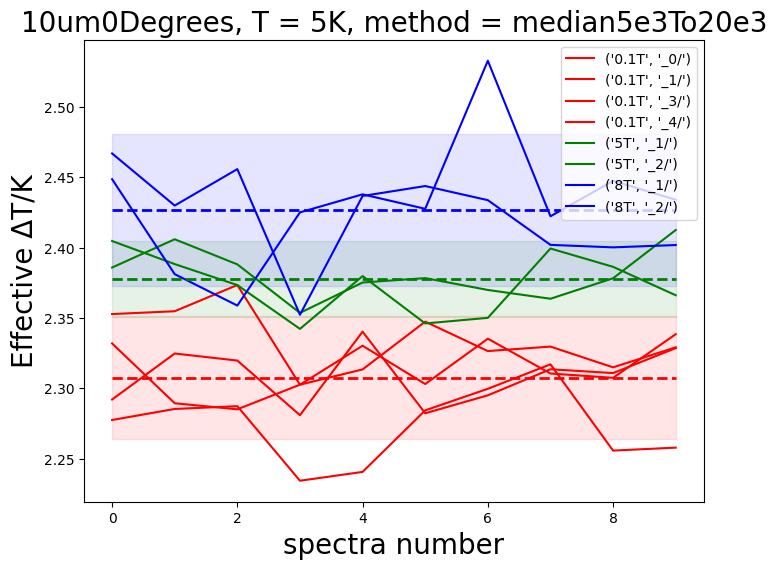

In [31]:
dataset = "10um0Degrees" # 10um0Degrees or data2um0Degrees
temperature = "5K" # 5K 10K or 20K
method = "median5e3To20e3" # median9e3To11e3 or median5e3To20e3
localEffectiveTs = pullOutKeys(pullOutKeys(effectiveTDifferences, 0)[dataset],(0,4))[(temperature, method)]
localMeans = pullOutKeys(pullOutKeys(effectiveTDifferencesMeans, 0)[dataset],(0,3))[(temperature, method)]
localStdDevs = pullOutKeys(pullOutKeys(effectiveTDifferencesStdDevs, 0)[dataset],(0,3))[(temperature, method)]

figure = plt.figure(figsize = (8,6));
axis = figure.add_subplot(1,1,1);
axis.set_title(dataset + ", T = " + temperature + ", method = " + method, fontsize = 20)
axis.set_xlabel("spectra number", fontsize = 20)
axis.set_ylabel("Effective ΔT/K", fontsize = 20)

for key, effectiveTs in pullOutKeys(localEffectiveTs, (0,1)).items():
    axis.plot(range(len(effectiveTs)), effectiveTs.values(), label = key, color = colors[key[0]])
    axis.legend()

for bField in pullOutKeys(localMeans, 0).keys():
    mean = np.mean(list(pullOutKeys(localMeans, 0)[bField].values()))
    stdDev = np.sqrt(sum([stdDev**2 for stdDev in pullOutKeys(localStdDevs, 0)[bField].values()]))
    axis.plot(range(10), [mean for _ in range(10)], color = colors[bField], linewidth = 2, linestyle='dashed')
    axis.fill_between(range(10), mean - stdDev, mean + stdDev, color = colors[bField], alpha = 0.1)

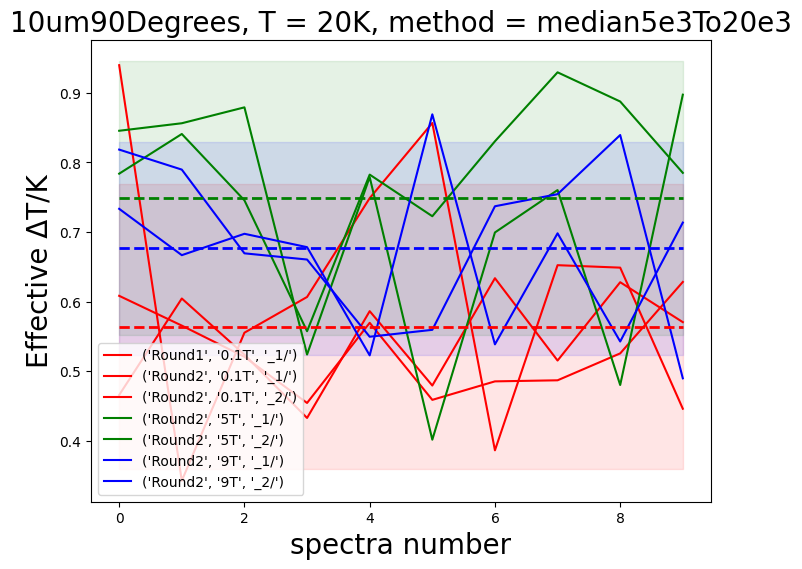

In [200]:
# 10um90Degrees
dataset = "10um90Degrees"
temperature = "20K" # 5K 10K or 20K
method = "median5e3To20e3" # median9e3To1e3 or median5e3To11e3
localEffectiveTs = {}
localMeans = {}
localStdDevs = {}
localEffectiveTs["Round1"] = pullOutKeys(pullOutKeys(effectiveTDifferences, 0)["10um90Degrees"],(0,4))[(temperature, method)]
localMeans["Round1"] = pullOutKeys(pullOutKeys(effectiveTDifferencesMeans, 0)["10um90Degrees"],(0,3))[(temperature, method)]
localStdDevs["Round1"] = pullOutKeys(pullOutKeys(effectiveTDifferencesStdDevs, 0)["10um90Degrees"],(0,3))[(temperature, method)]
localEffectiveTs["Round2"] = pullOutKeys(pullOutKeys(effectiveTDifferences, 0)["10um90DegreesRound2"],(0,4))[(temperature, method)]
localMeans["Round2"] = pullOutKeys(pullOutKeys(effectiveTDifferencesMeans, 0)["10um90DegreesRound2"],(0,3))[(temperature, method)]
localStdDevs["Round2"] = pullOutKeys(pullOutKeys(effectiveTDifferencesStdDevs, 0)["10um90DegreesRound2"],(0,3))[(temperature, method)]
localEffectiveTs = flattenKeys(localEffectiveTs)
localMeans = flattenKeys(localMeans)
localStdDevs = flattenKeys(localStdDevs)

figure = plt.figure(figsize = (8,6));
axis = figure.add_subplot(1,1,1);
axis.set_title(dataset + ", T = " + temperature + ", method = " + method, fontsize = 20)
axis.set_xlabel("spectra number", fontsize = 20)
axis.set_ylabel("Effective ΔT/K", fontsize = 20)

for key, effectiveTs in pullOutKeys(localEffectiveTs, (0,1,2)).items():
    axis.plot(range(len(effectiveTs)), effectiveTs.values(), label = key, color = colors[key[1]])
    axis.legend()

for bField in pullOutKeys(localMeans, 1).keys():
    mean = np.mean(list(pullOutKeys(localMeans, 1)[bField].values()))
    stdDev = np.sqrt(sum([stdDev**2 for stdDev in pullOutKeys(localStdDevs, 1)[bField].values()]))
    axis.plot(range(10), [mean for _ in range(10)], color = colors[bField], linewidth = 2, linestyle='dashed')
    axis.fill_between(range(10), mean - stdDev, mean + stdDev, color = colors[bField], alpha = 0.1)

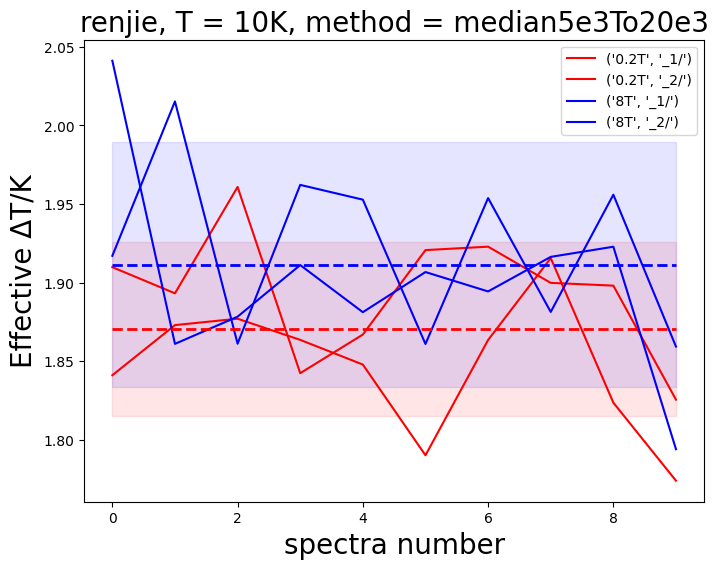

In [91]:
# renjie
dataset = "renjie"
temperature = "10K" # 5K or 10K
method = "median5e3To20e3" # median9e3To11e3 or median5e3To20e3
localEffectiveTs = pullOutKeys(pullOutKeys(effectiveTDifferences, 0)[dataset],(0,4))[(temperature, method)]
localMeans = pullOutKeys(pullOutKeys(effectiveTDifferencesMeans, 0)[dataset],(0,3))[(temperature, method)]
localStdDevs = pullOutKeys(pullOutKeys(effectiveTDifferencesStdDevs, 0)[dataset],(0,3))[(temperature, method)]

figure = plt.figure(figsize = (8,6));
axis = figure.add_subplot(1,1,1);
axis.set_title(dataset + ", T = " + temperature + ", method = " + method, fontsize = 20)
axis.set_xlabel("spectra number", fontsize = 20)
axis.set_ylabel("Effective ΔT/K", fontsize = 20)

for key, effectiveTs in pullOutKeys(localEffectiveTs, (0,1)).items():
    axis.plot(range(len(effectiveTs)), effectiveTs.values(), label = key, color = colors[key[0]])
    axis.legend()

for bField in pullOutKeys(localMeans, 0).keys():
    mean = np.mean(list(pullOutKeys(localMeans, 0)[bField].values()))
    stdDev = np.sqrt(sum([stdDev**2 for stdDev in pullOutKeys(localStdDevs, 0)[bField].values()]))
    axis.plot(range(10), [mean for _ in range(10)], color = colors[bField], linewidth = 2, linestyle='dashed')
    axis.fill_between(range(10), mean - stdDev, mean + stdDev, color = colors[bField], alpha = 0.1)

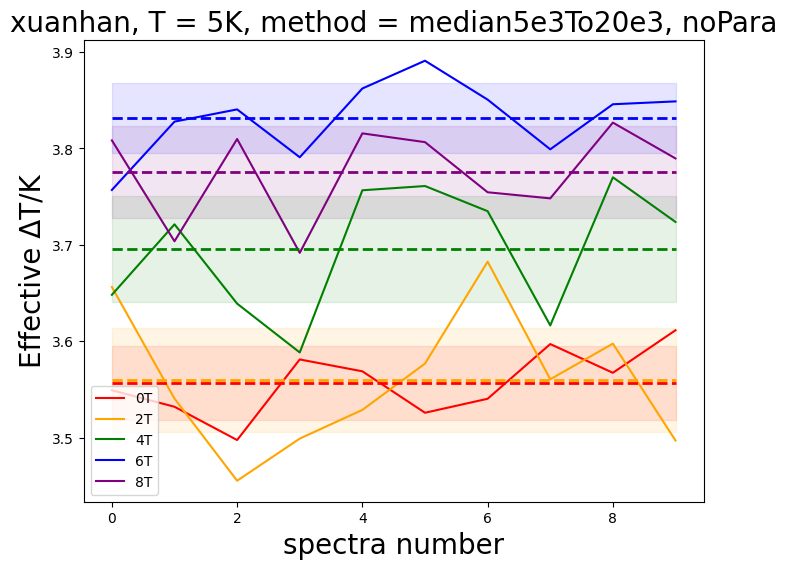

In [104]:
# xuanhan

dataset = "xuanhan"
para = "noPara" # para or noPara
method = "median5e3To20e3" # median9e3To11e3 or median5e3To20e3
localEffectiveTs = pullOutKeys(xuanhanEffectiveTDifferences,(0,3))[(para, method)]
localMeans = pullOutKeys(xuanhanEffectiveTDifferencesMeans,(0,2))[(para, method)]
localStdDevs = pullOutKeys(xuanhanEffectiveTDifferencesStdDevs,(0,2))[(para, method)]


figure = plt.figure(figsize = (8,6));
axis = figure.add_subplot(1,1,1);
axis.set_title(dataset + ", T = " + "5K" + ", method = " + method + ", " + para, fontsize = 20)
axis.set_xlabel("spectra number", fontsize = 20)
axis.set_ylabel("Effective ΔT/K", fontsize = 20)


for key, effectiveTs in pullOutKeys(localEffectiveTs, 0).items():
    axis.plot(range(len(effectiveTs)), effectiveTs.values(), label = key, color = xuanhanColors[key])
    axis.legend()

for bField in localMeans.keys():
    mean = localMeans[bField]
    stdDev = localStdDevs[bField]
    axis.plot(range(10), [mean for _ in range(10)], color = xuanhanColors[bField], linewidth = 2, linestyle='dashed')
    axis.fill_between(range(10), mean - stdDev, mean + stdDev, color = xuanhanColors[bField], alpha = 0.1)

### Style 1

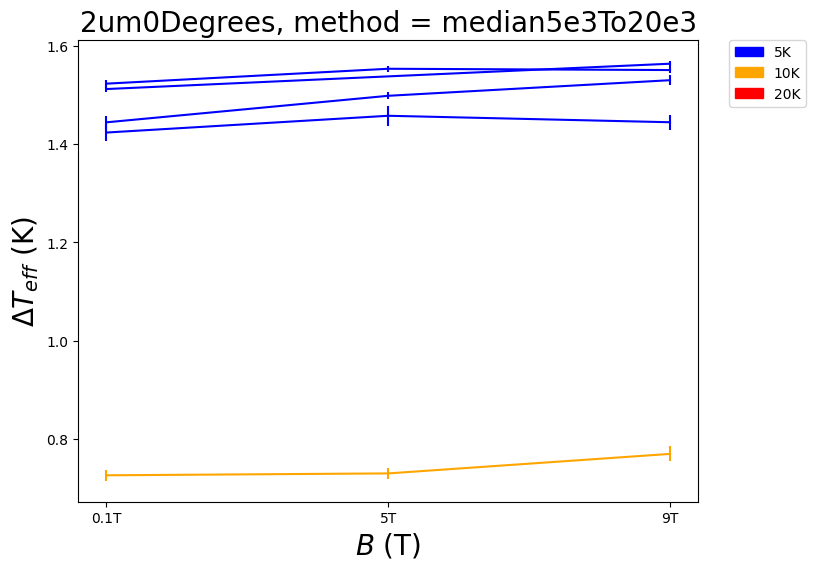

In [58]:
# For plotting everything besides the 10um90Degrees data and Xuanhan's data

dataset = "2um0Degrees" # 10um0Degrees or 2um0Degrees or renjie
method = "median5e3To20e3" # median9e3To11e3 or median5e3To20e3

figure = plt.figure(figsize = (8,6))
axis = figure.add_subplot(1,1,1)
axis.set_title(dataset + ", method = " + method, fontsize = 20)
axis.set_xlabel("$B$ (T)", fontsize = 20)
axis.set_ylabel("$\Delta T_{eff}$ (K)", fontsize = 20)
axis.legend(handles=[mpatches.Patch(color='blue', label='5K'),
                     mpatches.Patch(color='orange', label='10K'),
                     mpatches.Patch(color='red', label='20K')],
            bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

for (temp, run), keyedByFieldStat in pullOutKeys(effectiveTDifferencesStats, [(0,4), (0,2)])[(dataset, method)].items():
    fields, means, stdErrs = generalizedTranspose([(field, stats["mean"], stats["stdErr"]) for (field, stats) in pullOutKeys(keyedByFieldStat, 0).items()], [1,0])
    # draws only the points with no errorbars
    # axis.plot(fields, means, color = temperatureColors[temp])
    axis.errorbar(fields, means, yerr = stdErrs, color = temperatureColors[temp]) # use ls='none' to get rid of the lines
    # axis.scatter(fields, means, color = temperatureColors[temp])

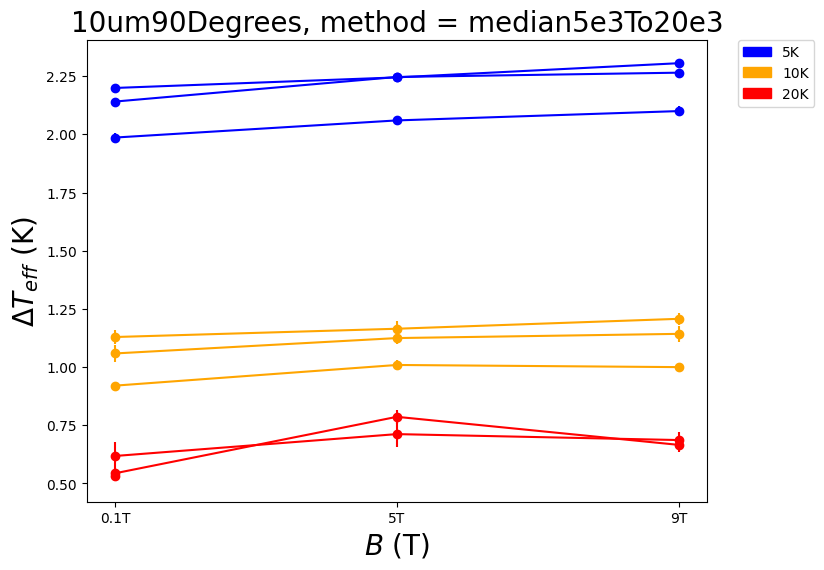

In [57]:
# For plotting the 10um90Degrees data

method = "median5e3To20e3" # median9e3To11e3 or median5e3To20e3

figure = plt.figure(figsize = (8,6))
axis = figure.add_subplot(1,1,1)
axis.set_title("10um90Degrees" + ", method = " + method, fontsize = 20)
axis.set_xlabel("$B$ (T)", fontsize = 20)
axis.set_ylabel("$\Delta T_{eff}$ (K)", fontsize = 20)
axis.legend(handles=[mpatches.Patch(color='blue', label='5K'), 
                     mpatches.Patch(color='orange', label='10K'), 
                     mpatches.Patch(color='red', label='20K')],
            bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

statsPulledOut = pullOutKeys(effectiveTDifferencesStats, [(0,4), (0,2)])
dataPoints = {**statsPulledOut[("10um90Degrees", method)], **toolz.keymap(lambda t : (t[0], "Round2" + t[1]), statsPulledOut[("10um90DegreesRound2", method)])}

for (temp, run), keyedByFieldStat in dataPoints.items():
    fields, means, stdErrs = generalizedTranspose([(field, stats["mean"], stats["stdErr"]) for (field, stats) in pullOutKeys(keyedByFieldStat, 0).items()], [1,0])
    # draws only the points with no errorbars
    # axis.plot(fields, means, color = temperatureColors[temp])
    axis.errorbar(fields, means, yerr = stdErrs, color = temperatureColors[temp]) # use ls='none' to get rid of the lines
    axis.scatter(fields, means, color = temperatureColors[temp])

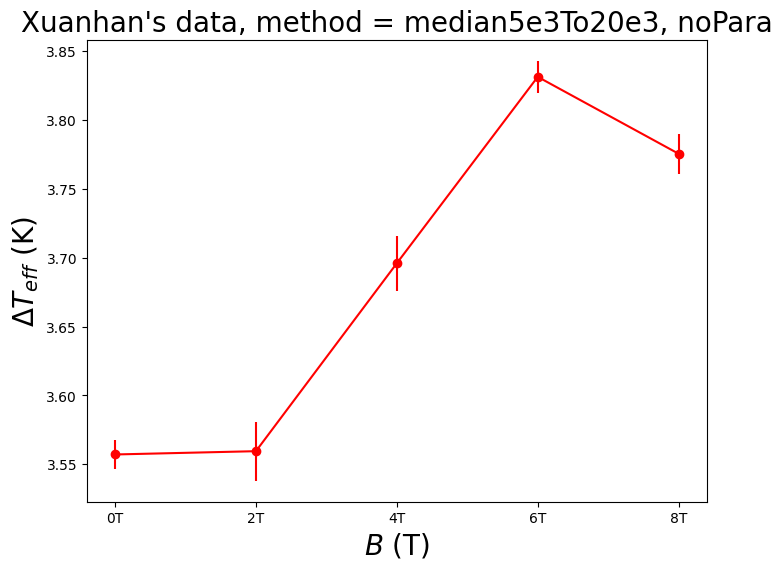

In [92]:
# for plotting Xuanhan's data
method = "median5e3To20e3" # median9e3To11e3 or median5e3To20e3
para = "noPara" # para or noPara

figure = plt.figure(figsize = (8,6))
axis = figure.add_subplot(1,1,1)
axis.set_title("Xuanhan's data" + ", method = " + method + ", " + para, fontsize = 20)
axis.set_xlabel("$B$ (T)", fontsize = 20)
axis.set_ylabel("$\Delta T_{eff}$ (K)", fontsize = 20)
# axis.legend(handles=[mpatches.Patch(color='blue', label='5K'),
#                      mpatches.Patch(color='orange', label='10K'),
#                      mpatches.Patch(color='red', label='20K')],
#             bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

fields, means, stdErrs = generalizedTranspose([(field, stats["mean"], stats["stdErr"]) for (field, stats) in pullOutKeys(xuanhanEffectiveTDifferencesStats, [(0, 2), 0])[(para, method)].items()], [1,0])
axis.errorbar(fields, means, yerr = stdErrs, color = temperatureColors[temp]) # use ls='none' to get rid of the lines
axis.scatter(fields, means, color = temperatureColors[temp])

### Style 2
Style 2: use 3 columns, one for each temperature

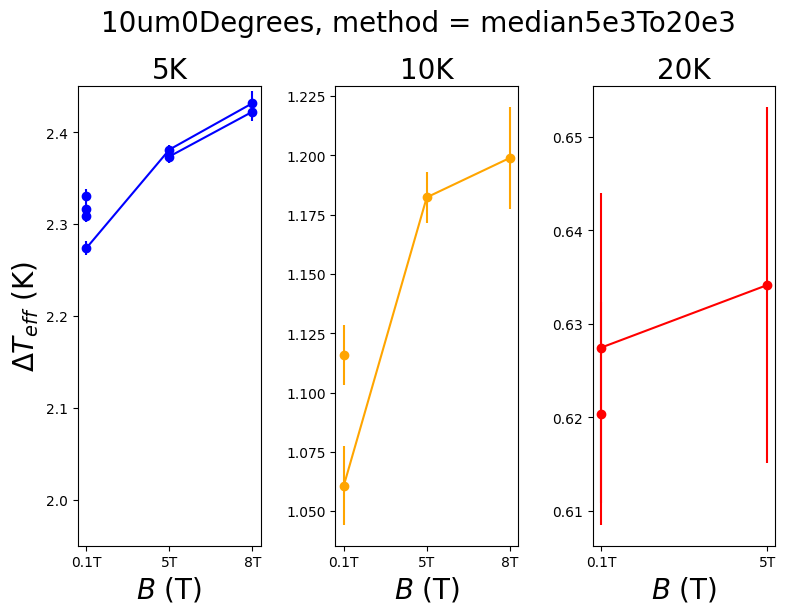

In [60]:
# For plotting everything besides the 10um90Degrees data

dataset = "10um0Degrees" # 10um0Degrees or 2um0Degrees or renjie
method = "median5e3To20e3" # median9e3To11e3 or median5e3To20e3

figure = plt.figure(figsize = (8,6))
axis5K = figure.add_subplot(1,3,1)
axis10K = figure.add_subplot(1,3,2)
axis20K = figure.add_subplot(1,3,3)

figure.suptitle(dataset + ", method = " + method, fontsize = 20)
figure.tight_layout(pad = 2)

axis5K.set_title("5K", fontsize = 20)
axis5K.set_xlabel("$B$ (T)", fontsize = 20)
axis5K.set_ylabel("$\Delta T_{eff}$ (K)", fontsize = 20)

axis10K.set_title("10K", fontsize = 20)
axis10K.set_xlabel("$B$ (T)", fontsize = 20)

axis20K.set_title("20K", fontsize = 20)
axis20K.set_xlabel("$B$ (T)", fontsize = 20)

for (temp, run), keyedByFieldStat in pullOutKeys(effectiveTDifferencesStats, [(0,4), (0,2)])[(dataset, method)].items():
    fields, means, stdErrs = generalizedTranspose([(field, stats["mean"], stats["stdErr"]) for (field, stats) in pullOutKeys(keyedByFieldStat, 0).items()], [1,0])
    axis = None
    if temp == "5K":
        axis = axis5K
    elif temp == "10K":
        axis = axis10K
    elif temp == "20K":
        axis = axis20K
    else:
        print("something went wrong")
    axis.errorbar(fields, means, yerr = stdErrs, color = temperatureColors[temp]) # use ls='none' to get rid of the lines
    axis.scatter(fields, means, color = temperatureColors[temp])

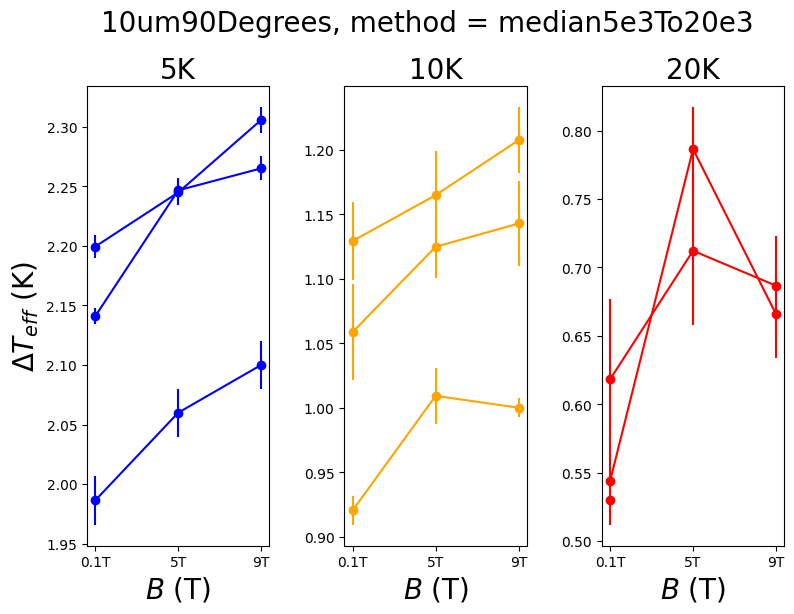

In [95]:
# For plotting the 10um90Degrees data

method = "median5e3To20e3" # median9e3To11e3 or median5e3To20e3

figure = plt.figure(figsize = (8,6))
axis5K = figure.add_subplot(1,3,1)
axis10K = figure.add_subplot(1,3,2)
axis20K = figure.add_subplot(1,3,3)

figure.suptitle("10um90Degrees" + ", method = " + method, fontsize = 20)
figure.tight_layout(pad = 2)

axis5K.set_title("5K", fontsize = 20)
axis5K.set_xlabel("$B$ (T)", fontsize = 20)
axis5K.set_ylabel("$\Delta T_{eff}$ (K)", fontsize = 20)

axis10K.set_title("10K", fontsize = 20)
axis10K.set_xlabel("$B$ (T)", fontsize = 20)

axis20K.set_title("20K", fontsize = 20)
axis20K.set_xlabel("$B$ (T)", fontsize = 20)

statsPulledOut = pullOutKeys(effectiveTDifferencesStats, [(0,4), (0,2)])
dataPoints = {**statsPulledOut[("10um90Degrees", method)], **toolz.keymap(lambda t : (t[0], "Round2" + t[1]), statsPulledOut[("10um90DegreesRound2", method)])}

for (temp, run), keyedByFieldStat in dataPoints.items():
    fields, means, stdErrs = generalizedTranspose([(field, stats["mean"], stats["stdErr"]) for (field, stats) in pullOutKeys(keyedByFieldStat, 0).items()], [1,0])
    axis = None
    if temp == "5K":
        axis = axis5K
    elif temp == "10K":
        axis = axis10K
    elif temp == "20K":
        axis = axis20K
    else:
        print("something went wrong")
    axis.errorbar(fields, means, yerr = stdErrs, color = temperatureColors[temp]) # use ls='none' to get rid of the lines
    axis.scatter(fields, means, color = temperatureColors[temp])

### Style 3
Style 3: Make the 0 degree and 90 columns have the same scale.
I'll only bother with the 10um plots for the time being. 

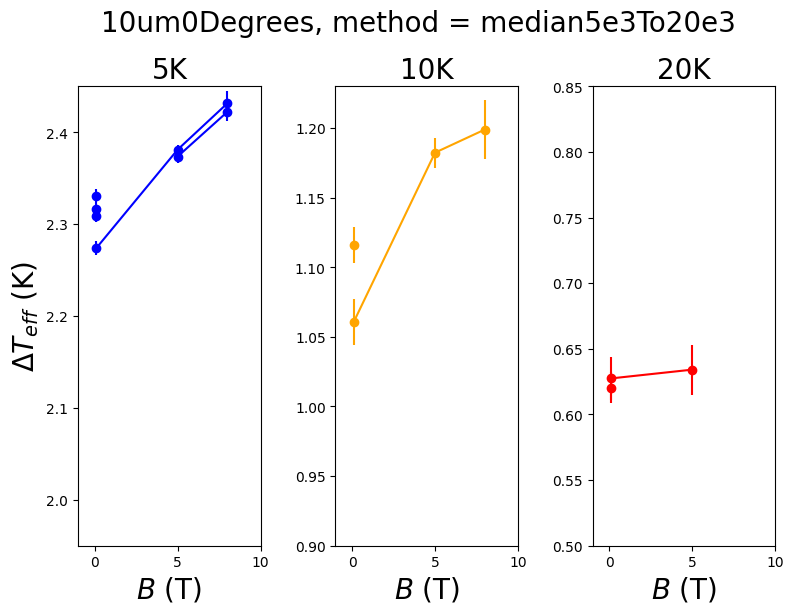

In [105]:
device = "10um0Degrees" # 10um0Degrees
method = "median5e3To20e3" # median9e3To11e3 or median5e3To20e3

figure = plt.figure(figsize = (8,6))
axis5K = figure.add_subplot(1,3,1)
axis10K = figure.add_subplot(1,3,2)
axis20K = figure.add_subplot(1,3,3)

figure.suptitle("10um0Degrees" + ", method = " + method, fontsize = 20)
figure.tight_layout(pad = 2)

axis5K.set_title("5K", fontsize = 20)
axis5K.set_xlabel("$B$ (T)", fontsize = 20)
axis5K.set_ylabel("$\Delta T_{eff}$ (K)", fontsize = 20)
axis5K.set_xlim(-1, 10)
axis5K.set_ylim(1.95, 2.45)

axis10K.set_title("10K", fontsize = 20)
axis10K.set_xlabel("$B$ (T)", fontsize = 20)
axis10K.set_xlim(-1, 10)
axis10K.set_ylim(0.9, 1.23)

axis20K.set_title("20K", fontsize = 20)
axis20K.set_xlabel("$B$ (T)", fontsize = 20)
axis20K.set_xlim(-1, 10)
axis20K.set_ylim(0.5, 0.85)

for (temp, run), keyedByFieldStat in pullOutKeys(effectiveTDifferencesStats, [(0,4), (0,2)])[(device, method)].items():
    fieldsDimensionalized, means, stdErrs = generalizedTranspose([(field, stats["mean"], stats["stdErr"]) for (field, stats) in pullOutKeys(keyedByFieldStat, 0).items()], [1,0])
    fields = [float(field[:-1]) for field in fieldsDimensionalized]
    axis = None
    if temp == "5K":
        axis = axis5K
    elif temp == "10K":
        axis = axis10K
    elif temp == "20K":
        axis = axis20K
    else:
        print("something went wrong")
    axis.errorbar(fields, means, yerr = stdErrs, color = temperatureColors[temp]) # use ls='none' to get rid of the lines
    axis.scatter(fields, means, color = temperatureColors[temp])

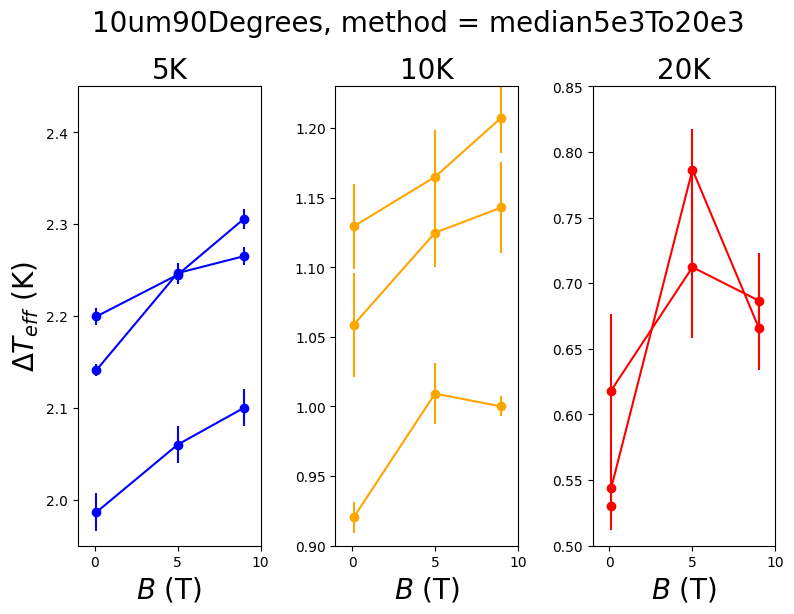

In [99]:
method = "median5e3To20e3" # median9e3To11e3 or median5e3To20e3

figure = plt.figure(figsize = (8,6))
axis5K = figure.add_subplot(1,3,1)
axis10K = figure.add_subplot(1,3,2)
axis20K = figure.add_subplot(1,3,3)

figure.suptitle("10um90Degrees" + ", method = " + method, fontsize = 20)
figure.tight_layout(pad = 2)

axis5K.set_title("5K", fontsize = 20)
axis5K.set_xlabel("$B$ (T)", fontsize = 20)
axis5K.set_ylabel("$\Delta T_{eff}$ (K)", fontsize = 20)
axis5K.set_xlim(-1, 10)
axis5K.set_ylim(1.95, 2.45)

axis10K.set_title("10K", fontsize = 20)
axis10K.set_xlabel("$B$ (T)", fontsize = 20)
axis10K.set_xlim(-1, 10)
axis10K.set_ylim(0.9, 1.23)

axis20K.set_title("20K", fontsize = 20)
axis20K.set_xlabel("$B$ (T)", fontsize = 20)
axis20K.set_xlim(-1, 10)
axis20K.set_ylim(0.5, 0.85)

statsPulledOut = pullOutKeys(effectiveTDifferencesStats, [(0,4), (0,2)])
dataPoints = {**statsPulledOut[("10um90Degrees", method)], **toolz.keymap(lambda t : (t[0], "Round2" + t[1]), statsPulledOut[("10um90DegreesRound2", method)])}

for (temp, run), keyedByFieldStat in dataPoints.items():
    fieldsDimensionalized, means, stdErrs = generalizedTranspose([(field, stats["mean"], stats["stdErr"]) for (field, stats) in pullOutKeys(keyedByFieldStat, 0).items()], [1,0])
    fields = [float(field[:-1]) for field in fieldsDimensionalized]
    axis = None
    if temp == "5K":
        axis = axis5K
    elif temp == "10K":
        axis = axis10K
    elif temp == "20K":
        axis = axis20K
    else:
        print("something went wrong")
    axis.errorbar(fields, means, yerr = stdErrs, color = temperatureColors[temp]) # use ls='none' to get rid of the lines
    axis.scatter(fields, means, color = temperatureColors[temp])

### Style 4
Squeeze both the 0 and 90 degree data on the same plot

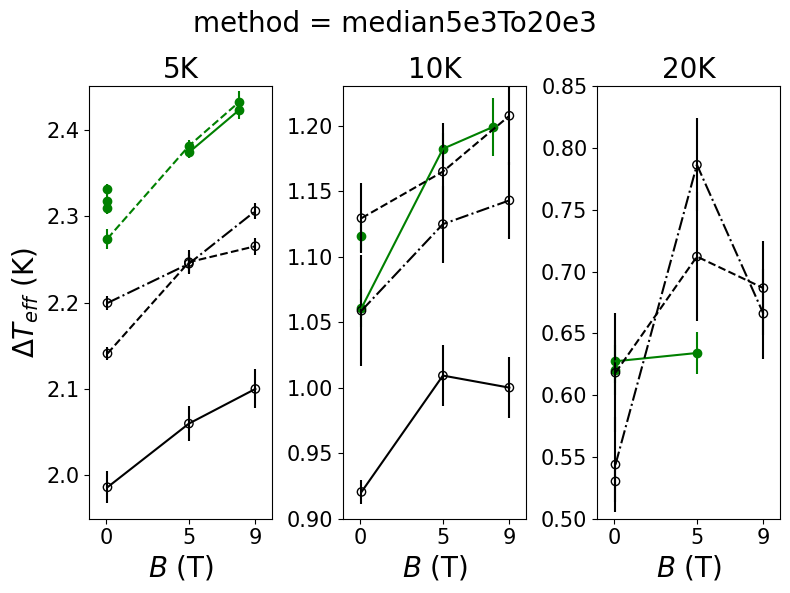

In [141]:
# theres only 4 styles so I just repeated it several times
lineStyles = ["-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":"]
lineStyleIndex = 0

dataset = "10um0Degrees" # 10um0Degrees
method = "median5e3To20e3" # median9e3To11e3 or median5e3To20e3

figure = plt.figure(figsize = (8,6))

axis5K = figure.add_subplot(1,3,1)
axis10K = figure.add_subplot(1,3,2)
axis20K = figure.add_subplot(1,3,3)

figure.suptitle("method = " + method, fontsize = 20)
figure.tight_layout(pad = 2)

axis5K.set_title("5K", fontsize = 20)
axis5K.set_xlabel("$B$ (T)", fontsize = 20)
axis5K.set_ylabel("$\Delta T_{eff}$ (K)", fontsize = 20)
axis5K.set_xlim(-1, 10)
axis5K.set_ylim(1.95, 2.45)
axis5K.set_xticks([0, 5, 9])
axis5K.tick_params(axis='both', which='major', labelsize=15)

axis10K.set_title("10K", fontsize = 20)
axis10K.set_xlabel("$B$ (T)", fontsize = 20)
axis10K.set_xlim(-1, 10)
axis10K.set_ylim(0.9, 1.23)
axis10K.set_xticks([0, 5, 9])
axis10K.tick_params(axis='both', which='major', labelsize=15)

axis20K.set_title("20K", fontsize = 20)
axis20K.set_xlabel("$B$ (T)", fontsize = 20)
axis20K.set_xlim(-1, 10)
axis20K.set_ylim(0.5, 0.85)
axis20K.set_xticks([0, 5, 9])
axis20K.tick_params(axis='both', which='major', labelsize=15)

for temp, keyedByRunThenFieldStat in pullOutKeys(effectiveTDifferencesStats, [(0,4), 0, 1])[(dataset, method)].items():
    lineStyleIndex = 0
    for run, keyedByFieldStat in keyedByRunThenFieldStat.items():
        fieldsDimensionalized, means, stdErrs = generalizedTranspose([(field, stats["mean"], stats["stdErr"]) for (field, stats) in pullOutKeys(keyedByFieldStat, 0).items()], [1,0])
        fields = [float(field[:-1]) for field in fieldsDimensionalized]
        axis = None
        if temp == "5K":
            axis = axis5K
        elif temp == "10K":
            axis = axis10K
        elif temp == "20K":
            axis = axis20K
        else:
            print("something went wrong")
        axis.errorbar(fields, means, yerr = stdErrs, fmt = lineStyles[lineStyleIndex], color = "green") # use ls='none' to get rid of the lines
        axis.scatter(fields, means, color = "green")
        lineStyleIndex = lineStyleIndex + 1
    
lineStyleIndex = 0
statsPulledOut = pullOutKeys(effectiveTDifferencesStats, [(0,4), (0,2)])
dataPoints = {**statsPulledOut[("10um90Degrees", method)], **toolz.keymap(lambda t : (t[0], "Round2" + t[1]), statsPulledOut[("10um90DegreesRound2", method)])}
for temp, keyedByRunThenFieldStat in pullOutKeys(dataPoints, 0).items():
    lineStyleIndex = 0
    for run, keyedByFieldStat in keyedByRunThenFieldStat.items():
        fieldsDimensionalized, means, stdErrs = generalizedTranspose([(field, stats["mean"], stats["stdErr"]) for (field, stats) in pullOutKeys(keyedByFieldStat, 0).items()], [1,0])
        fields = [float(field[:-1]) for field in fieldsDimensionalized]
        axis = None
        if temp == "5K":
            axis = axis5K
        elif temp == "10K":
            axis = axis10K
        elif temp == "20K":
            axis = axis20K
        else:
            print("something went wrong")
        axis.errorbar(fields, means, yerr = stdErrs, fmt = lineStyles[lineStyleIndex], color = "black") # use ls='none' to get rid of the lines
        axis.scatter(fields, means, facecolors='none', edgecolors='black')
        lineStyleIndex = lineStyleIndex + 1
        
# figure.tight_layout()
# figure.savefig("/home/tanner/desk/xuanhanYIGNoisePaper/figures/fig3noLegend.svg", format="svg")

## Making other plots for the paper

### Fig 1c
SSE measured with AC techniques at selected temperatures.

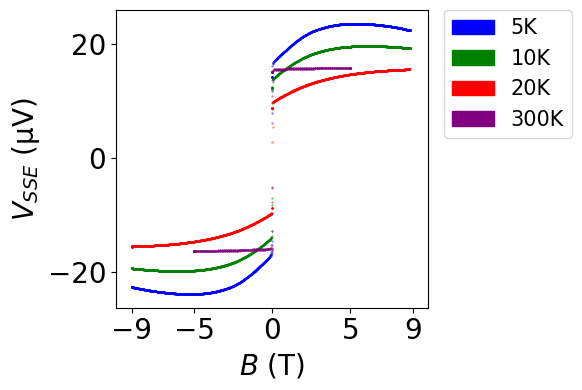

In [138]:
sseColors = {
    "5K": "blue",
    "10K": "green", 
    "20K": "red", 
    "300K": "purple"
}

# This is for the device transverse to the field, alpha = 0, so the effect should be strong
sseFilenames = search(["5K", "10K", "20K", "300K"], include = ["newYIGData", "10umFrom20230107", "VvsB"], unique = True)
sseData = {temperature : getData(filename) for temperature, filename in sseFilenames.items()}

figure = plt.figure(figsize = (6,4))
# figure.suptitle("SSE vs B, $V_{2y}$", fontsize=20)
axis = figure.add_subplot(1,1,1)
axis.legend(
    handles=[mpatches.Patch(color=color, label=temperature) for temperature, color in sseColors.items()],
    bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,
    fontsize = 15
)
axis.set_xlabel("$B$ (T)", fontsize=20)
axis.set_xlim(-10,10)
axis.set_xticks([-9, -5, 0, 5, 9])
axis.set_ylabel("$V_{SSE}$ (μV)", fontsize=20)
axis.tick_params(axis='both', which='major', labelsize=20)

for i in range(0,4):
    temperature = ["5K", "10K", "20K", "300K"][i]
    fieldValues = sseData[temperature][:, 0] / 1e4
    values = sseData[temperature][:,4] * 1e6
    axis.scatter(fieldValues, values, s = 0.1, color = sseColors[temperature])
    
# figure.tight_layout()
# figure.savefig("/home/tanner/desk/xuanhanYIGNoisePaper/figures/fig1c.svg", format="svg")

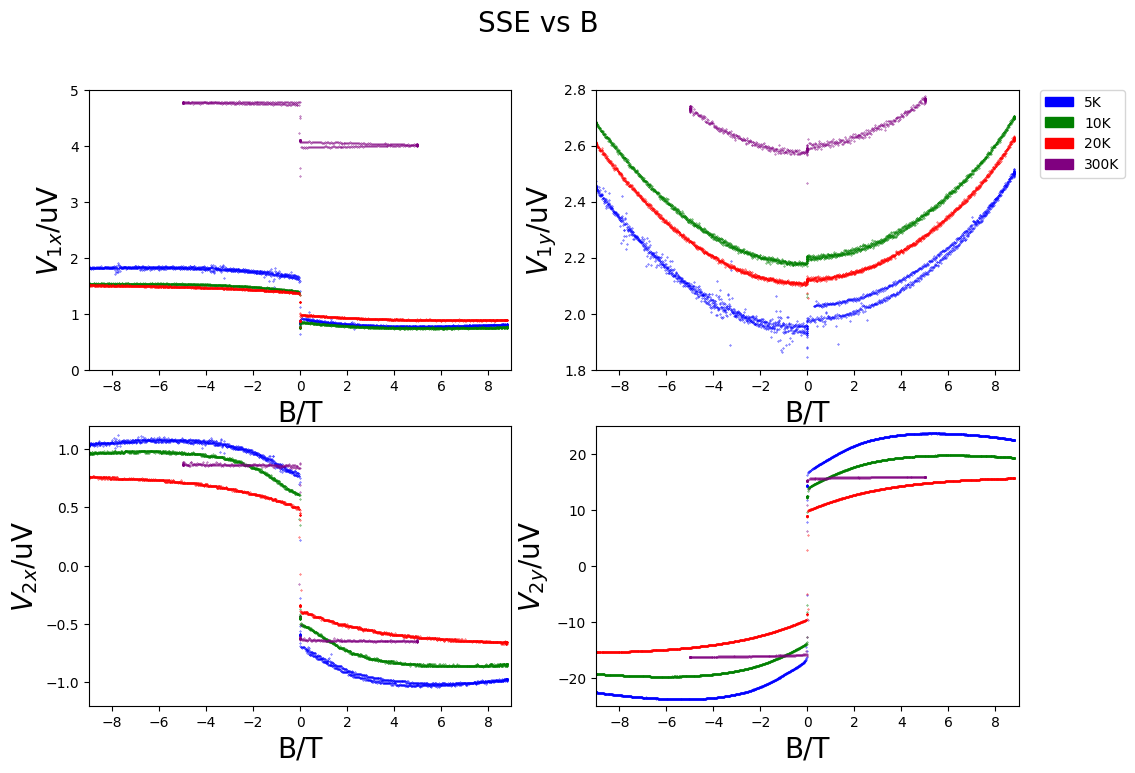

In [22]:
sseColors = {
    "5K": "blue",
    "10K": "green", 
    "20K": "red", 
    "300K": "purple"
}

# This is for the device transverse to the field, alpha = 0, so the effect should be strong
sseFilenames = search(["5K", "10K", "20K", "300K"], include = ["newYIGData", "10umFrom20230107", "VvsB"], unique = True)
sseData = {temperature : getData(filename) for temperature, filename in sseFilenames.items()}


figure = plt.figure(figsize = (12,8))
figure.suptitle("SSE vs B", fontsize=20)

for i in range(4):
    axis = figure.add_subplot(2, 2, i + 1)
    for temperature in ["5K", "10K", "20K", "300K"]:
        fieldValues = sseData[temperature][:, 0] / 1e4
        values = sseData[temperature][:,i + 1] * 1e6
        axis.scatter(fieldValues, values, s = 0.1, color = sseColors[temperature])

figure.axes[0].set_xlabel("B/T", fontsize=20)
figure.axes[0].set_ylabel("$V_{1x}$/uV", fontsize=20)
figure.axes[0].set_xlim([-9, 9])
figure.axes[0].set_ylim([0, 5])

figure.axes[1].set_xlabel("B/T", fontsize=20)
figure.axes[1].set_ylabel("$V_{1y}$/uV", fontsize=20)
figure.axes[1].set_xlim([-9, 9])
figure.axes[1].set_ylim([1.8, 2.8])

figure.axes[2].set_xlabel("B/T", fontsize=20)
figure.axes[2].set_ylabel("$V_{2x}$/uV", fontsize=20)
figure.axes[2].set_xlim([-9, 9])
figure.axes[2].set_ylim([-1.2, 1.2])

figure.axes[3].set_xlabel("B/T", fontsize=20)
figure.axes[3].set_ylabel("$V_{2y}$/uV", fontsize=20)
figure.axes[3].set_xlim([-9, 9])
figure.axes[3].set_ylim([-25, 25])

figure.axes[1].legend(
    handles=[mpatches.Patch(color=color, label=temperature) for temperature, color in sseColors.items()],
    bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.
)

### Fig 1d

Make important note of the README in the `10umFrom20230105` folder. In particular where it says
> The currents and powers in file `10umFrom20230105/VvsI_T_300K_B_0_5T_alpha_0.dat` and `10umFrom20230105/VvsI_T_5K_B_0_5T_alpha_0.dat` were calculated from the Vpp. Its better to calculate from Vrms = Vpp / sqrt(2). In particular, since the power should be calculated from an rms current value not a peak to peak it is off by a factor of two. The currents in this file should be divided by sqrt(2) to correct them and the powers should be divided by 2 to correct them. 

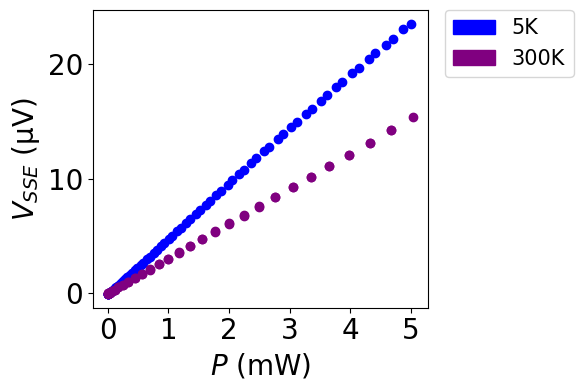

In [140]:
sseColors = {
    "5K": "blue",
    "10K": "green", 
    "20K": "red", 
    "300K": "purple"
}

figure = plt.figure(figsize = (6,4))
# figure.suptitle("SSE vs P, $V_{2y}$", fontsize=20)
axis = figure.add_subplot(1,1,1)
axis.legend(
    handles=[mpatches.Patch(color="blue", label="5K"), mpatches.Patch(color="purple", label="300K")],
    bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,
    fontsize = 15
)
axis.set_xlabel("$P$ (mW)", fontsize=20)
# axis.set_xlim(0,5.5)
axis.set_xticks([0, 1, 2, 3, 4, 5])
axis.set_ylabel("$V_{SSE}$ (μV)", fontsize=20)
axis.tick_params(axis='both', which='major', labelsize=20)

# These are in the format of I V1x V1y P V2x V2y
sseVsP5K = getData(search(include = ["newYIGData/10umFrom20230107/VvsI_T_5K_B_0_5T_alpha_0.dat"])[0])
# didn't take a 300K run in the 10umFrom20230107 folder, I'll use the one from two days earlier
sseVsP300K = getData(search(include = ["newYIGData/10umFrom20230105/VvsI_T_300K_B_0_5T_alpha_0.dat"])[0])
# note theres also a 5K run in 10umFrom20230105, its bizarre though, the sign is flipped and theres weird 
# nonlinearity at low powers, I'm willing to say its because a gold contact was about to break but who knows

powers5K, v2ys5K = sseVsP5K[:,(3,5)].transpose()
powers5K = powers5K * 1e3
v2ys5K = v2ys5K * 1e6
powers300K, v2ys300K = sseVsP300K[:,(3,5)].transpose()
powers300K = powers300K * 1e3
v2ys300K = v2ys300K * 1e6
powers300K = powers300K / 2 # see markdown cell above or the README

axis.scatter(powers5K, v2ys5K, color = sseColors["5K"])
axis.scatter(powers300K, v2ys300K, color = sseColors["300K"])


# figure.tight_layout()
# figure.savefig("/home/tanner/desk/xuanhanYIGNoisePaper/figures/fig1d.svg", format="svg")

### Fig 2b

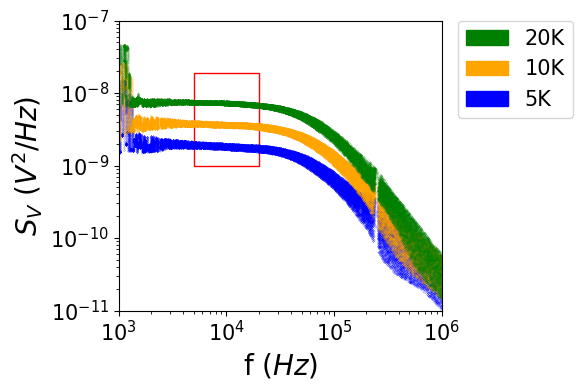

In [75]:
device = '10um0Degrees'
field = "0.1T"

figure = plt.figure(figsize = (6,4))
# figure.suptitle("example spectra", fontsize=20)
axis = figure.add_subplot(1,1,1)
axis.set_xlim(1e3, 1e6)
axis.set_ylim(1e-11, 1e-7)
axis.set_xscale("log")
axis.set_yscale("log")
axis.tick_params(axis='both', which='major', labelsize=15)
figure.axes[0].add_patch(mpatches.Rectangle((5e3, 1e-9), 15e3, 2e-8 - 2e-9, linewidth=1, edgecolor='red', facecolor='none'))
axis.legend(
    handles=[mpatches.Patch(color="green", label="20K"),
             mpatches.Patch(color="orange", label="10K"),
             mpatches.Patch(color="blue", label="5K")],
    bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,
    fontsize = 15
)
axis.set_xlabel("f ($Hz$)", fontsize=20)
axis.set_ylabel("$S_V$ ($V^2/Hz$)", fontsize=20)

for temperature, color in [("5K", "blue"), ("10K", "orange"), ("20K", "green")]:
    spectrum = Spectrum.fromFilename(filenames[(device, temperature, field, '0mW', '_1/', '0.00V')], 4000)
    background = backgrounds[(device, field)]
    data5K = (spectrum - background).data
    data5KLogLogged = np.log10(np.abs(np.delete(data5K, 0, axis=0))).transpose()

    # lets make evenly spaced data
    interpolation5K = scipy.interpolate.interp1d(*data5KLogLogged)
    fLogged = np.linspace(1,6, num=100000)
    data5KLogLoggedEvenlySpaced = interpolation5K(fLogged)

    # now lets do a windowed middle 60% quantile and make interpolations of that
    windowSize = 0.3
    lowerQuantileLimit = 0.2
    upperQuantileLimit = 0.8
    reduceOverXAxisWindows(0.2, np.median, fLogged, data5KLogLoggedEvenlySpaced)
    [medianFs, quantileSs] = reduceOverXAxisWindows(
        windowSize, 
        lambda ss: [np.quantile(ss, lowerQuantileLimit), np.quantile(ss, upperQuantileLimit)], 
        fLogged, 
        data5KLogLoggedEvenlySpaced, 
        windowOverlap = 0.75
    )
    lowerQuantileInterpolation = scipy.interpolate.interp1d(medianFs, np.array(quantileSs)[:,0], bounds_error=False, fill_value="extrapolate")
    upperQuantileInterpolation = scipy.interpolate.interp1d(medianFs, np.array(quantileSs)[:,1], bounds_error=False, fill_value="extrapolate")
    # plt.plot(medianFs, lowerQuantileInterpolation(medianFs), color="orange")
    # plt.plot(medianFs, upperQuantileInterpolation(medianFs), color="orange")

    # now lets filter out points not between those quantiles
    [filteredFs, filteredSs] = np.array([[f, s] for [f, s] in np.array([fLogged, data5KLogLoggedEvenlySpaced]).transpose() if (lowerQuantileInterpolation(f) < s and s < upperQuantileInterpolation(f))]).transpose()
    
    # now we unlog the data
    filteredFs = 10**filteredFs
    filteredSs = 10**filteredSs
    
    # and plot it on a log plot
    # note later: use rasterized=True to make the data points png while the rest of the plot stays svg
    # this helps Inkscape, Word, and other programs alot when displaying the plot
    # when using rasterized=True, don't forget dpi=300 in the savefig call
    axis.scatter(filteredFs, filteredSs, s=0.01, color=color, rasterized=True)
    

figure.tight_layout()
figure.savefig("/home/tanner/desk/xuanhanYIGNoisePaper/figures/fig2b.svg", format="svg", dpi=300)

### Fig 2c

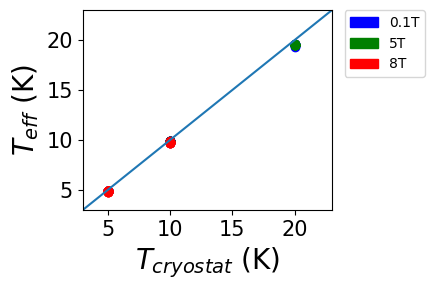

In [60]:
# use 10um0Degrees and median5e3To20e3 and 0mW to reproduce Fig 2c of the paper
device = '10um0Degrees' # 10um0Degrees or 10um90Degrees or 2um0Degrees or 10um90DegreesRound2
method = 'median5e3To20e3' # median5e3To20e3 or median5e3To20e3WithOneBackground
power = "0mW" # 0mW or 5mW

figure2cColors = {
    "0.1T" : "blue",
    "0.2T" : "blue",
    "5T" : "green",
    "8T" : "red",
    "9T": "red"
}

figure = plt.figure(figsize = (4.5,3))
axis = figure.add_subplot(1,1,1)
# axis.set_title(device + ", method = " + method, fontsize = 20)
axis.set_xlabel("$T_{cryostat}$ (K)", fontsize = 20)
axis.set_ylabel("$T_{eff}$ (K)", fontsize = 20)
axis.tick_params(axis='both', which='major', labelsize=15)
axis.set_xticks([5, 10, 15, 20])
axis.set_yticks([5, 10, 15, 20])
fields = list(pullOutKeys(normalizedEffectiveTs, [(0, 3, 6), 1])[(device, power, method)].keys())
axis.legend(handles=[mpatches.Patch(color=figure2cColors[field], label=field) for field in fields],
            bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
axis.set_xlim(3, 23)
axis.set_ylim(3, 23)
axis.plot(range(0,25), range(0, 25))

for field, keyedByTempRunSubrun in pullOutKeys(normalizedEffectiveTs, [(0, 3, 6), 1])[(device, power, method)].items():
    cryostatTemperaturesDimensionalized, effectiveTemperatures = generalizedTranspose([(key[0], value) for key, value in keyedByTempRunSubrun.items()], [1,0])
    cryostatTemperatures = [float(field[:-1]) for field in cryostatTemperaturesDimensionalized]
    axis.scatter(cryostatTemperatures, effectiveTemperatures, color = figure2cColors[field])
    
figure.tight_layout()
figure.savefig("/home/tanner/desk/xuanhanYIGNoisePaper/figures/fig2c.svg", format="svg")

## Supplementary Material plots

### SSE of the 10um Rice device with field parallel to wire

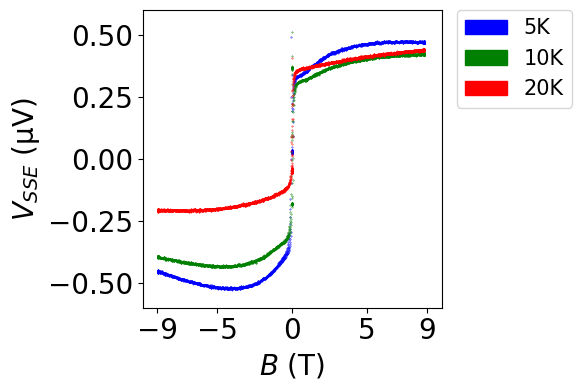

In [28]:
# Since Ba much smaller signal is observed, further confirming the observed signal is due to the spin Seebeck effect
sseFilenames90Degrees = {
    "5K": r"/home/tanner/desk/ppmsComputer/LSSEOnYIG/newYIGData/10umFrom20230222/VvsB_T_5K_alpha_90_P_5mW.dat",
    "10K": r"/home/tanner/desk/ppmsComputer/LSSEOnYIG/newYIGData/10umFrom20230222/VvsB_T_10K_alpha_90_P_5mW.dat",
    "20K": r"/home/tanner/desk/ppmsComputer/LSSEOnYIG/newYIGData/10umFrom20230222/VvsB_T_20K_alpha_90_P_5mW.dat"
}

# sseFilenames2um = search(["5K", "300K"], include = ["2umFrom20230210", "vs", ".dat"], dontInclude=[], unique=True)
# sseData2um = {temperature : getData(filename) for temperature, filename in sseFilenames2um.items()}

figure = plt.figure(figsize = (6,4))
# figure.suptitle("SSE vs B, $V_{2y}$", fontsize=20)
axis = figure.add_subplot(1,1,1)
axis.legend(
    handles=[mpatches.Patch(color=color, label=temperature) for temperature, color in {"5K": "blue", "10K": "green", "20K": "red"}.items()],
    bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,
    fontsize = 15
)
axis.set_xlabel("$B$ (T)", fontsize=20)
axis.set_xlim(-10,10)
axis.set_ylim(-0.6,0.6)
axis.set_xticks([-9, -5, 0, 5, 9])
axis.set_ylabel("$V_{SSE}$ (μV)", fontsize=20)
axis.tick_params(axis='both', which='major', labelsize=20)

for temperature, color in {"5K": "blue", "10K": "green", "20K": "red"}.items():
    data = getData(sseFilenames90Degrees[temperature])
    fieldValues = data[:, 0] / 1e4
    values = data[:,4] * -1e6
    axis.scatter(fieldValues, values, s = 0.1, color = color)
    
figure.tight_layout()
figure.savefig("/home/tanner/desk/xuanhanYIGNoisePaper/figures/supplementaryMaterial/sseOfRice10umDevice90Degrees.svg", format="svg")

### SSE of the 2um device

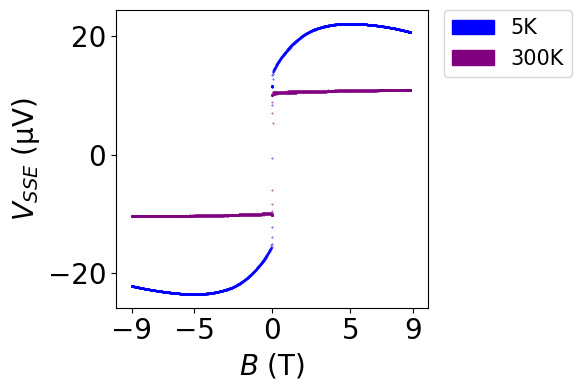

In [168]:
sseFilenames2um = search(["5K", "300K"], include = ["2umFrom20230210", "vs", ".dat"], dontInclude=[], unique=True)
sseData2um = {temperature : getData(filename) for temperature, filename in sseFilenames2um.items()}

figure = plt.figure(figsize = (6,4))
# figure.suptitle("SSE vs B, $V_{2y}$", fontsize=20)
axis = figure.add_subplot(1,1,1)
axis.legend(
    handles=[mpatches.Patch(color=color, label=temperature) for temperature, color in {"5K": "blue", "300K": "purple"}.items()],
    bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,
    fontsize = 15
)
axis.set_xlabel("$B$ (T)", fontsize=20)
axis.set_xlim(-10,10)
axis.set_xticks([-9, -5, 0, 5, 9])
axis.set_ylabel("$V_{SSE}$ (μV)", fontsize=20)
axis.tick_params(axis='both', which='major', labelsize=20)

for temperature, color in {"5K": "blue", "300K": "purple"}.items():
    fieldValues = sseData2um[temperature][:, 0] / 1e4
    values = sseData2um[temperature][:,4] * 1e6
    axis.scatter(fieldValues, values, s = 0.1, color = color)
    
figure.tight_layout()
figure.savefig("/home/tanner/desk/xuanhanYIGNoisePaper/figures/supplementaryMaterial/sseOfRice2umDevice.svg", format="svg")

### Noise of the 2um device

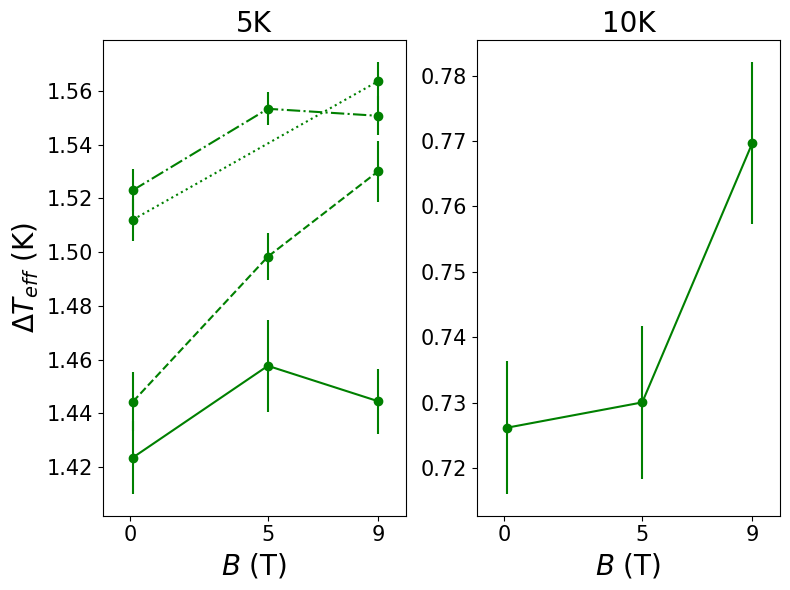

In [180]:
# theres only 4 styles so I just repeated it several times
lineStyles = ["-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":"]
lineStyleIndex = 0

dataset = "2um0Degrees" # 10um0Degrees or 2um0Degrees
method = "median5e3To20e3" # median9e3To11e3 or median5e3To20e3

figure = plt.figure(figsize = (8,6))

axis5K = figure.add_subplot(1,2,1)
axis10K = figure.add_subplot(1,2,2)
# axis20K = figure.add_subplot(1,3,3)

# figure.suptitle("method = " + method, fontsize = 20)
figure.tight_layout(pad = 2)

axis5K.set_title("5K", fontsize = 20)
axis5K.set_xlabel("$B$ (T)", fontsize = 20)
axis5K.set_ylabel("$\Delta T_{eff}$ (K)", fontsize = 20)
axis5K.set_xlim(-1, 10)
# axis5K.set_ylim(1.95, 2.45)
axis5K.set_xticks([0, 5, 9])
axis5K.tick_params(axis='both', which='major', labelsize=15)

axis10K.set_title("10K", fontsize = 20)
axis10K.set_xlabel("$B$ (T)", fontsize = 20)
axis10K.set_xlim(-1, 10)
# axis10K.set_ylim(0.9, 1.23)
axis10K.set_xticks([0, 5, 9])
axis10K.tick_params(axis='both', which='major', labelsize=15)

for temp, keyedByRunThenFieldStat in pullOutKeys(effectiveTDifferencesStats, [(0,4), 0, 1])[(dataset, method)].items():
    lineStyleIndex = 0
    for run, keyedByFieldStat in keyedByRunThenFieldStat.items():
        fieldsDimensionalized, means, stdErrs = generalizedTranspose([(field, stats["mean"], stats["stdErr"]) for (field, stats) in pullOutKeys(keyedByFieldStat, 0).items()], [1,0])
        fields = [float(field[:-1]) for field in fieldsDimensionalized]
        axis = None
        if temp == "5K":
            axis = axis5K
        elif temp == "10K":
            axis = axis10K
        else:
            print("something went wrong")
        axis.errorbar(fields, means, yerr = stdErrs, fmt = lineStyles[lineStyleIndex], color = "green") # use ls='none' to get rid of the lines
        axis.scatter(fields, means, color = "green")
        lineStyleIndex = lineStyleIndex + 1

figure.tight_layout()
figure.savefig("/home/tanner/desk/xuanhanYIGNoisePaper/figures/supplementaryMaterial/noiseOf2umRiceDevice.svg", format="svg")

### SSE of the Argonne device

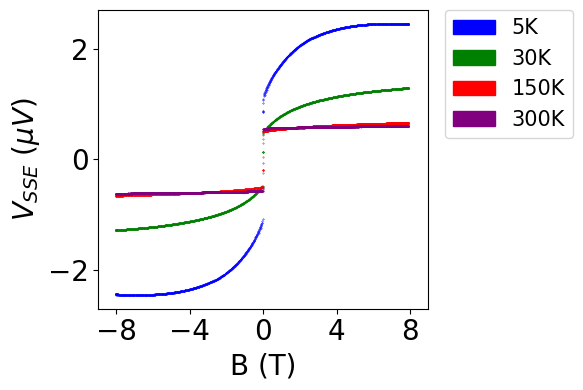

In [29]:
xuanhanSSEColors = {
    "5K": "blue",
    "30K": "green", 
    "150K": "red", 
    "300K": "purple"
}

# fields are in Tesla, voltages are in uV, only the V2y voltages are given
xuanhanSSEvsBFilenames = search(["5K", "30K", "150K", "300K"], include=["Xuanhan Data", "VSSEvsB"], dontInclude=[], unique=True)
xuanhanSSEvsBData = toolz.valmap(getData, xuanhanSSEvsBFilenames)

figure = plt.figure(figsize = (6,4))
axis = figure.add_subplot(1,1,1)
axis.legend(
    handles=[mpatches.Patch(color=color, label=temperature) for temperature, color in xuanhanSSEColors.items()],
    bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,
    fontsize = 15
)
axis.set_xlabel("B (T)", fontsize=20)
axis.set_xlim(-9,9)
axis.set_xticks([-8, -4, 0, 4, 8])
axis.set_ylabel("$V_{SSE}$ ($\mu V$)", fontsize=20)
axis.tick_params(axis='both', which='major', labelsize=20)

for temperature, color in xuanhanSSEColors.items():
    fieldValues = xuanhanSSEvsBData[temperature][:, 0]
    values = xuanhanSSEvsBData[temperature][:,1] * -1
    axis.scatter(fieldValues, values, s = 0.1, color = color)
    
figure.tight_layout()
figure.savefig("/home/tanner/desk/xuanhanYIGNoisePaper/figures/supplementaryMaterial/sseOfArgonneDevice.svg", format="svg")

### Magnetoresistance of the Pt wire on the 10um Rice device

who cares
who cares
who cares
who cares
who cares
who cares


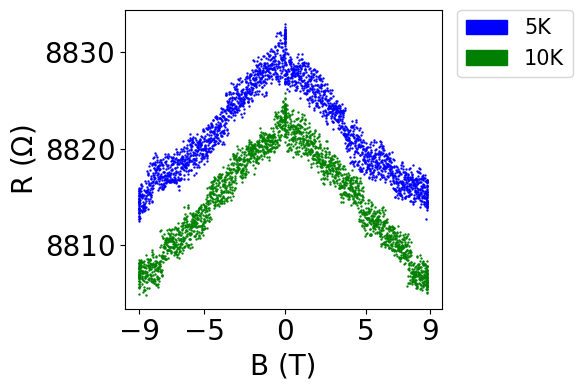

In [156]:
figure = plt.figure(figsize = (6,4))
axis = figure.add_subplot(1,1,1)
axis.legend(
    handles=[mpatches.Patch(color=color, label=label) for label, color in {"5K": "blue", "10K": "green"}.items()],
    bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,
    fontsize = 15
)
axis.set_xlabel("B (T)", fontsize=20)
# axis.set_xlim(0,5.5)
axis.set_xticks([-9, -5, 0, 5, 9])
axis.set_ylabel("R ($\Omega$)", fontsize=20)
axis.tick_params(axis='both', which='major', labelsize=20)

ptMRFilenames = flattenKeys(search(["5K", "10K", "20K"], {"0Degrees": "alpha_0", "90Degrees": "alpha=90"}, include=["R_PtvsB"]))
for (temperature, angle), filenames in ptMRFilenames.items():
    for filename in filenames:
        [fields, resistances] = getData(filename)[:, (1,4)].transpose()
        fields = fields / 1e4
        resistances = resistances
        color = {"5K": "blue", "10K": "green", "20K": "red"}[temperature]
        if angle == "0Degrees":
            axis.scatter(fields, resistances, color=color, s=0.5)
            # print("who cares")
        elif angle == "90Degrees":
            # axis.scatter(fields, resistances, color=color, facecolors='none')
            print("who cares")
        else:
            print("something went wrong")

figure.tight_layout()
figure.savefig("/home/tanner/desk/xuanhanYIGNoisePaper/figures/supplementaryMaterial/mrOfPtWire.svg", format="svg", dpi=300)

### Magnetoresistance of the Au wire on the 10um Rice device

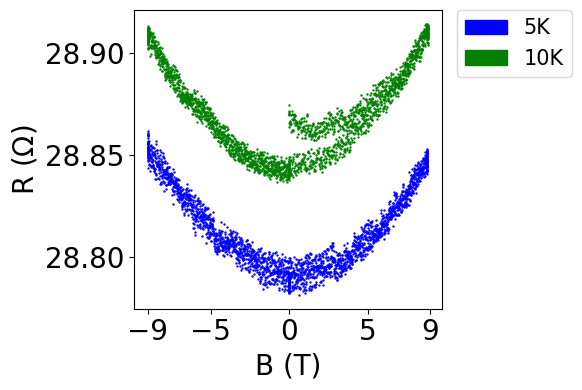

In [155]:
figure = plt.figure(figsize = (6,4))
axis = figure.add_subplot(1,1,1)
axis.legend(
    handles=[mpatches.Patch(color=color, label=label) for label, color in {"5K": "blue", "10K": "green"}.items()],
    bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,
    fontsize = 15
)
axis.set_xlabel("B (T)", fontsize=20)
# axis.set_xlim(0,5.5)
axis.set_xticks([-9, -5, 0, 5, 9])
axis.set_ylabel("R ($\Omega$)", fontsize=20)
axis.tick_params(axis='both', which='major', labelsize=20)

auMRFilenames = {
    "5K": r"/home/tanner/desk/ppmsComputer/LSSEOnYIG/newYIGData/10umFrom20230107/R_AuvsB_T_5K_alpha_0.dat",
    "10K": r"/home/tanner/desk/ppmsComputer/LSSEOnYIG/newYIGData/10umFrom20230107/R_AuvsB_T_10K_alpha_0.dat"
}
for temperature, filename in auMRFilenames.items():
    [fields, resistances] = getData(filename)[:, (1,4)].transpose()
    fields = fields / 1e4
    resistances = resistances
    color = {"5K": "blue", "10K": "green", "20K": "red"}[temperature]
    axis.scatter(fields, resistances, color=color, s=0.5)
    
figure.tight_layout()
figure.savefig("/home/tanner/desk/xuanhanYIGNoisePaper/figures/supplementaryMaterial/mrOfAuWire.svg", format="svg", dpi=300)

## messing around

In [36]:
(8900 * 7.5e-9 * 10e-6 / 800e-6)**-1

1198501.8726591761

In [ ]:
    # groupSpectra is now an indexed series, can I convert it to a dictionary?
    for spectrum in groupSpectra:
        spectrum.filteredData = None
        spectrum.filters = [lambda f, s: f > 9e3 and f < 11e3]
        median = np.median(spectrum.getFilteredData()[:, 1])
        spectrum.fitParameters = np.array([median])

In [ ]:
data10um0Degrees = data10um0DegreesAverageDictionary
data2um0Degrees = data2um0DegreesAverageDictionary
data10um90Degrees = data10um90DegreesAverageDictionary

In [ ]:
fitSpectrumWithLine(data2um0Degrees[('10K', '9T', '_1/', '5mW')], )
data2um0Degrees[('10K', '9T', '_1/', '5mW')].plot(plotFitLineQ=True, plotFilteredDataQ=True, plotDataQ=True, ylim=[1e-12, 1e-7])

In [ ]:
Spectrum.plotSpectra([data2um0Degrees[('10K', '9T', '_1/', '0mW')], data2um0Degrees[('10K', '9T', '_1/', '5mW')]], ["blue", "red"])

In [ ]:
data = mr10um90Degrees["5K"][:,[1,4]]
figure = plt.figure(figsize = (8,6));
axis = figure.add_subplot(1,1,1);
axis.set_title("R vs B @ alpha=90, T=5K for 10um device", fontsize = 20)
# axis.set_xlim(xlim);
# axis.set_ylim(ylim);
axis.set_xlabel("B/Oe", fontsize = 20)
axis.set_ylabel("R/Ohms", fontsize = 20)
axis.scatter(data[:,0], data[:,1], s=0.5)

dataSmoothed = smoothData(mr10um90Degrees["5K"][:,[1,4]])

In [ ]:
mrData = mr10um90Degrees["20K"]
dataSeries = pd.Series(data = mrData[:,4], index = mrData[:,1])
dataSeriesSmoothed = dataSeries.rolling(window=50).mean().dropna()
dataSeriesSmoothed.plot()
# dataInterpolation = scipy.interpolate.interp1d(dataSeriesSmoothed.index, dataSeriesSmoothed.values)
# mrInterpolations.append(dataInterpolation)

In [ ]:
def constantFunction(f, fitParameter0):
        return fitParameter0

for spectrum in data2um0Degrees.values():
    spectrum.modelFunction = constantFunction
    spectrum.initialGuess = [1.5e-9 / 5 * 5]
    spectrum.filteredData = None
    spectrum.filters = 
    spectrum.fitParameters = None
    spectrum.getFitParameters()
data2um0DegreesEffectiveTs = toolz.valmap(lambda spectrum: spectrum.getEffectiveT(), data2um0Degrees)


In [ ]:
data = {"10umFrom20230222" : {"5K" : {"0mW" : "one", "5mW" : "two"}, "10K" : {"0mW" : "three", "5mW" : "four"}}, 
 "2umFrom20230210" : {"5K" : {"0mW" : "five", "5mW" : "six"}, "10K" : {"0mW" : "seven", "5mW" : "eight"}}, 
 "10umFrom20220105" : {"5K" : {"0mW" : "nine", "5mW" : "ten"}, "10K" : {"0mW" : "eleven", "5mW" : "twelve"}}}

["10umFrom20230222", "5K", "0mW"] : "one" # What I had in MMA
{"set": "10umFrom20230222", "T": "5K", "P": "0mW"} : "one" # what I should really be using
{"set": "10umFrom20230222", "T": "5K", "P": "0mW", "data" : "one"} # technically equivalent
# what if I have two datasets/spectra associated to a given key, use a tuple
{"set": "10umFrom20230222", "T": "5K", "P": "0mW"} : (spectraOne, spectraTwo)
# but tuples are just dictionaries with implicit number labels
{"set": "10umFrom20230222", "T": "5K", "P": "0mW", "first": spectraOne, "second": spectraTwo} # arguably equivalent
{"set": "10umFrom20230222", "T": "5K", "P": "0mW"} : {"first": spectraOne, "second": spectraTwo} # arguably equivalent
{"set": "10umFrom20230222", "T": "5K", "P": "0mW", "first": spectraOne, "second": spectraTwo} # technically equivalent
# only difference between the "T" and the "first" attribute is that ("set", "T", "P") can uniquely index the elements
# whereas ("set", "first", "P") cannot
# note ("set", "T", "P") : ("10umFrom20230222", "5K", "0mW") == {"set:"10umFrom20230222"", "T" :"5K", "P" :"0mW"}

# Appendix A: Making the averages

In [ ]:
# Inputs a directory, assumes all .dat files in the directory are spectra
# it averages them and prints the average as a spectrum file to the directory
def printAverageToDirectory(directory, filename = "average.dat"):
    filenames = search(include = [directory, ".dat"])
    spectra = list(map(lambda f : Spectrum.fromFilename(f, 4000), filenames))
    average = Spectrum.averageSpectra(spectra)
    average.printToFile(directory + "/average.dat")

filenamesNoXuanhan = toolz.keyfilter(lambda key: key[0] != "xuanhan", filenames)

This code calculates the averages of, and prints the averages to, all relevant directories of spectra for storage

In [ ]:
counterBox = widgets.Output(layout={'border': '1px solid black'})
counterBox

In [ ]:
# all directories containing spectra that are used in this analysis
# excluding xuanhan's files since those need no averaging
spectraDirectories = list(dict.fromkeys(map(os.path.dirname, filenamesNoXuanhan.values())))

# This code prints the average to each directory
# It should only need to run once
counter = 0
for directory in spectraDirectories:
    printAverageToDirectory(directory)
    
    # for the nice little counter display
    counter = counter + 1
    counterBox.clear_output()
    with counterBox:
        print(str(counter) + "/" + str(len(spectraDirectories)), 'directories averaged')

# Appendix B: Making the backgrounds

Assuming the averages have already been printed to the directories, this code loads in the averages (which are used to calculate the backgrounds).

In [105]:
# we can't calculate backgrounds for Xuanhan's data because its all at 5K, nothing's at 10K
# the averages mostly serve to calculate the backgrounds so I won't calculate them for Xuanhan's data, 
# it would also require reorganizing his data to match my and Renjie's organization but that would mess a little bit with my existing code so...
filenamesNoXuanhan = toolz.keyfilter(lambda key: key[0] != "xuanhan", filenames)
filenameAverages = {tupleDropElements(key,5): filename for key,filename in toolz.valmap(lambda f: os.path.dirname(f) + "/average.dat", filenamesNoXuanhan).items()}
averages = toolz.valmap(lambda f : Spectrum.fromFilenameMemo(f, 4000), filenameAverages)

This code calculates all relevant backgrounds saving them in the variable `backgrounds` (hopefully this code only ever needs to be run once (it takes a couple minutes on my computer)).

In [ ]:
# The backgrounds should be calculated with no applied power

# should I average over the rounds? not all rounds can give their own background since plenty of rounds don't have 10K data, 
# so either we throw out those rounds in the analysis or we allow them to borrow the backgrounds of other rounds, this would 
# be somewhat statistically unjustified if we didn't then have all rounds use the same background, this background will be 
# calculated as the average of the backgrounds of all the rounds from which backgrounds can be calculated

backgroundsPreRoundAveraging = {}
for key, spectra in toolz.valfilter(lambda val: "5K" in val and "10K" in val, pullOutKeys(pullOutKeys(averages, 3)["0mW"], (0,2,3))).items():
    backgroundsPreRoundAveraging[key] = 2 * spectra["5K"] - spectra["10K"]

backgrounds = {}
for key, val in pullOutKeys(backgroundsPreRoundAveraging, (0,1)).items():
    backgrounds[key] = Spectrum.averageSpectra(list(val.values()))
    
# # Note the all the 2um0Degrees and all the 10um90DegreesRound2 backgrounds are different looking from the other backgrounds, see
# Spectrum.plotSpectra(pullOutKeys(backgroundsPreRoundAveraging,0)["2um0Degrees"])
# Spectrum.plotSpectra(pullOutKeys(backgroundsPreRoundAveraging,0)["10um90DegreesRound2"])
# Spectrum.plotSpectra(backgrounds)

# I'm gonna assume they're fine and there simply was a different background during those data runs

This saves the backgrounds to files in the appropriate directories

In [ ]:
# the directory a background with a given key needs to be printed to
backgroundDirectories = toolz.valmap(lambda val : os.path.dirname(os.path.dirname(list(val.values())[0])), pullOutKeys(filenamesNoXuanhan, (0,2)))

for key, background in backgrounds.items():
    background.printToFile(backgroundDirectories[key] + "/background_" + key[1] + ".txt")